# Setup

In [109]:
%run ../setup.ipynb 

# carico dati

In [110]:
# cartella dove ci sono i dati da analizzare
folder = "../setup_dati/"

# importo dati
df_all = pd.read_csv(folder+"df_all_data.csv", sep=',').drop(columns=['Unnamed: 0'])
df_all["doc_index"] = df_all["doc_index"].apply(str)

In [111]:
df_all = calcola_scarto(df_all)

# Analisi

In [112]:
df_all = df_all.rename(columns={"doc_speaker's-trustworthiness_index": "doc_speaker_trustworthiness_index"})

In [113]:
df_all["correct_false"] = 0
df_all["correct_true"] = 0
df_all["wrong_false"] = 0
df_all["wrong_true"] = 0

df_all["correct"] = 0

for index, row in df_all.iterrows():
    if row ["quartile"] == "correct_false":
        df_all.loc[index, "correct_false"] = 1
        df_all.loc[index, "correct"] = 1
        
    if row ["quartile"] == "correct_true":
        df_all.loc[index, "correct_true"] = 1
        df_all.loc[index, "correct"] = 1
    if row ["quartile"] == "wrong_false":
        df_all.loc[index, "wrong_false"] = 1
    if row ["quartile"] == "wrong_true":
        df_all.loc[index, "wrong_true"] = 1
        

In [114]:
# creo i vari df per le analisi
def crea_df_per_analisi(df_analisi):
    df_all = df_analisi.copy()

    df_false = df_analisi[df_analisi["sovra"] == "pants-on-fire"]
    df_true = df_analisi[df_analisi["sovra"] == "true"]

    df_wrong_false = df_analisi[df_analisi["quartile"] == "wrong_false"]
    df_correct_false = df_analisi[df_analisi["quartile"] == "correct_false"]
    df_wrong_true = df_analisi[df_analisi["quartile"] == "wrong_true"]
    df_correct_true = df_analisi[df_analisi["quartile"] == "correct_true"]

    df_wrong = df_wrong_false.append(df_wrong_true)
    df_correct = df_correct_true.append(df_correct_false)

    DF_no_quartili = [["df_all",df_all],["df_false",df_false],["df_true",df_true],["df_wrong",df_wrong],["df_correct",df_correct]]
    DF = [["df_all",df_all],["df_false",df_false],["df_true",df_true],["df_wrong",df_wrong],["df_correct",df_correct],["df_wrong_false",df_wrong_false],["df_correct_false",df_correct_false],["df_correct_true",df_correct_true],["df_wrong_true",df_wrong_true]]
    return df_all, df_false, df_true , df_wrong, df_correct, df_wrong_false, df_correct_false, df_correct_true, df_wrong_true, DF_no_quartili, DF

In [115]:
df_all, df_false, df_true , df_wrong, df_correct, df_wrong_false, df_correct_false, df_correct_true, df_wrong_true, DF_no_quartili, DF = crea_df_per_analisi(df_all)

In [116]:
dimensioni_da_analizzare = ["doc_completeness_index","doc_comprehensibility_index","doc_precision_index","doc_informativeness_index","doc_unbiasedness_index","doc_accuracy_index","doc_speaker_trustworthiness_index","doc_confidence_index"]
quartili = ["wrong_false", "correct_false", "wrong_true", "correct_true"]

In [117]:
df_false["doc_speaker_trustworthiness_index"]

2       1.0
7       0.0
12      2.0
23      4.0
25      3.0
       ... 
1170    3.0
1178    2.0
1186    2.0
1188    2.0
1193    0.0
Name: doc_speaker_trustworthiness_index, Length: 199, dtype: float64

In [118]:
for variabile_interesse in ["scarto","doc_truthfulness_index", "mean"]:
    for df in DF_no_quartili:
        
        
        results = ols(
            f'''
                {variabile_interesse} ~ doc_completeness_index + doc_comprehensibility_index + doc_precision_index + doc_informativeness_index + doc_unbiasedness_index + doc_accuracy_index + doc_speaker_trustworthiness_index + doc_confidence_index"""
            '''
            , data=df[1]).fit()
        aov_table = sm.stats.anova_lm(results, typ=2)
        anova_table_v = anova_table(aov_table)
        if anova_table_v["omega_sq"].max() > 0.14:
            print("-" * 100)
            print(f"""{variabile_interesse} ~ doc_completeness_index + doc_comprehensibility_index + doc_precision_index + doc_informativeness_index + doc_unbiasedness_index + doc_accuracy_index + doc_speaker_trustworthiness_index + doc_confidence_index in {df[0]}""")
            display(anova_table_v.sort_values(by="omega_sq", ascending=False))
            
        for index, row in anova_table_v.iterrows():
            if row["omega_sq"] > 0.14:
                print(index)
                tukey_results = pairwise_tukeyhsd(endog=df[1][variabile_interesse], 
                                        groups=df[1][index], 
                                        alpha=0.05)
                
                df_turkey = pd.DataFrame(data=tukey_results._results_table.data[1:], columns=tukey_results._results_table.data[0])
                display(df_turkey[df_turkey["reject"] == True].sort_values(by="p-adj", ascending=True))

----------------------------------------------------------------------------------------------------
scarto ~ doc_completeness_index + doc_comprehensibility_index + doc_precision_index + doc_informativeness_index + doc_unbiasedness_index + doc_accuracy_index + doc_speaker_trustworthiness_index + doc_confidence_index in df_false


,sum_sq,df,mean_sq,F,PR(>F),eta_sq,omega_sq
doc_speaker_trustworthiness_index,42.657901,1.0,42.657901,35.695661,1.116925e-08,0.145921,0.141256
doc_accuracy_index,10.712667,1.0,10.712667,8.964241,3.119425e-03,0.036645,0.032425
doc_informativeness_index,5.886579,1.0,5.886579,4.925825,2.764129e-02,0.020136,0.015983
doc_confidence_index,4.463286,1.0,4.463286,3.734829,5.477605e-02,0.015268,0.011134
doc_comprehensibility_index,0.687862,1.0,0.687862,0.575595,4.489843e-01,0.002353,-0.001728
doc_unbiasedness_index,0.371897,1.0,0.371897,0.311200,5.776017e-01,0.001272,-0.002804
doc_precision_index,0.267806,1.0,0.267806,0.224097,6.364793e-01,0.000916,-0.003159
doc_completeness_index,0.228146,1.0,0.228146,0.190910,6.626562e-01,0.000780,-0.003294
Residual,227.058443,190.0,1.195044,NaN,NaN,NaN,NaN


doc_speaker_trustworthiness_index


,group1,group2,meandiff,p-adj,lower,upper,reject
1,0.0,2.0,2.1519,0.0000,1.5498,2.7539,True
2,0.0,3.0,3.1361,0.0000,2.4552,3.8170,True
3,0.0,4.0,3.4391,0.0000,2.6567,4.2216,True
5,1.0,3.0,2.0528,0.0000,1.2928,2.8128,True
6,1.0,4.0,2.3558,0.0000,1.5036,3.2081,True
0,0.0,1.0,1.0833,0.0001,0.4150,1.7516,True
8,2.0,4.0,1.2873,0.0002,0.4859,2.0886,True
4,1.0,2.0,1.0686,0.0003,0.3783,1.7589,True
7,2.0,3.0,0.9842,0.0014,0.2817,1.6867,True


----------------------------------------------------------------------------------------------------
scarto ~ doc_completeness_index + doc_comprehensibility_index + doc_precision_index + doc_informativeness_index + doc_unbiasedness_index + doc_accuracy_index + doc_speaker_trustworthiness_index + doc_confidence_index in df_true


,sum_sq,df,mean_sq,F,PR(>F),eta_sq,omega_sq
doc_accuracy_index,51.949769,1.0,51.949769,61.543700,2.994007e-13,2.352445e-01,0.230541
doc_speaker_trustworthiness_index,6.115183,1.0,6.115183,7.244517,7.742996e-03,2.769142e-02,0.023778
doc_comprehensibility_index,0.795848,1.0,0.795848,0.942823,3.327809e-01,3.603843e-03,-0.000218
doc_confidence_index,0.546815,1.0,0.546815,0.647799,4.219015e-01,2.476144e-03,-0.001341
doc_precision_index,0.184525,1.0,0.184525,0.218602,6.406401e-01,8.355842e-04,-0.002975
doc_completeness_index,0.012785,1.0,0.012785,0.015147,9.021801e-01,5.789604e-05,-0.003750
doc_informativeness_index,0.002628,1.0,0.002628,0.003113,9.555645e-01,1.189885e-05,-0.003796
doc_unbiasedness_index,0.000200,1.0,0.000200,0.000237,9.877236e-01,9.073352e-07,-0.003807
Residual,161.225370,191.0,0.844112,NaN,NaN,NaN,NaN


doc_accuracy_index


,group1,group2,meandiff,p-adj,lower,upper,reject
2,0.0,3.0,-2.5235,0.0000,-3.3083,-1.7388,True
3,0.0,4.0,-3.2682,0.0000,-4.0469,-2.4895,True
5,1.0,3.0,-2.0565,0.0000,-2.8174,-1.2956,True
6,1.0,4.0,-2.8012,0.0000,-3.5558,-2.0465,True
7,2.0,3.0,-1.0788,0.0000,-1.6353,-0.5224,True
8,2.0,4.0,-1.8235,0.0000,-2.3713,-1.2756,True
9,3.0,4.0,-0.7447,0.0000,-1.1813,-0.3080,True
1,0.0,2.0,-1.4447,0.0001,-2.2964,-0.5931,True
4,1.0,2.0,-0.9777,0.0120,-1.8074,-0.1479,True


----------------------------------------------------------------------------------------------------
doc_truthfulness_index ~ doc_completeness_index + doc_comprehensibility_index + doc_precision_index + doc_informativeness_index + doc_unbiasedness_index + doc_accuracy_index + doc_speaker_trustworthiness_index + doc_confidence_index in df_all


,sum_sq,df,mean_sq,F,PR(>F),eta_sq,omega_sq
doc_accuracy_index,288.433437,1.0,288.433437,231.574896,6.437323e-48,0.157543,0.156756
doc_speaker_trustworthiness_index,54.185297,1.0,54.185297,43.503814,6.350052e-11,0.029596,0.028896
doc_comprehensibility_index,2.443627,1.0,2.443627,1.961918,1.615691e-01,0.001335,0.000654
doc_confidence_index,1.293372,1.0,1.293372,1.038411,3.083984e-01,0.000706,0.000026
doc_informativeness_index,1.224158,1.0,1.224158,0.982841,3.216999e-01,0.000669,-0.000012
doc_unbiasedness_index,0.618825,1.0,0.618825,0.496837,4.810313e-01,0.000338,-0.000342
doc_precision_index,0.257296,1.0,0.257296,0.206575,6.495480e-01,0.000141,-0.000539
doc_completeness_index,0.182931,1.0,0.182931,0.146870,7.016127e-01,0.000100,-0.000580
Residual,1482.180475,1190.0,1.245530,NaN,NaN,NaN,NaN


doc_accuracy_index


,group1,group2,meandiff,p-adj,lower,upper,reject
0,0.0,1.0,1.0116,0.0,0.7130,1.3103,True
1,0.0,2.0,2.0165,0.0,1.7115,2.3216,True
2,0.0,3.0,2.8735,0.0,2.6014,3.1456,True
3,0.0,4.0,3.4046,0.0,3.1150,3.6942,True
4,1.0,2.0,1.0049,0.0,0.6992,1.3106,True
5,1.0,3.0,1.8618,0.0,1.5890,2.1347,True
6,1.0,4.0,2.3929,0.0,2.1026,2.6833,True
7,2.0,3.0,0.8569,0.0,0.5771,1.1367,True
8,2.0,4.0,1.3881,0.0,1.0912,1.6849,True
9,3.0,4.0,0.5311,0.0,0.2682,0.7940,True


----------------------------------------------------------------------------------------------------
doc_truthfulness_index ~ doc_completeness_index + doc_comprehensibility_index + doc_precision_index + doc_informativeness_index + doc_unbiasedness_index + doc_accuracy_index + doc_speaker_trustworthiness_index + doc_confidence_index in df_false


,sum_sq,df,mean_sq,F,PR(>F),eta_sq,omega_sq
doc_speaker_trustworthiness_index,42.657901,1.0,42.657901,35.695661,1.116925e-08,0.145921,0.141256
doc_accuracy_index,10.712667,1.0,10.712667,8.964241,3.119425e-03,0.036645,0.032425
doc_informativeness_index,5.886579,1.0,5.886579,4.925825,2.764129e-02,0.020136,0.015983
doc_confidence_index,4.463286,1.0,4.463286,3.734829,5.477605e-02,0.015268,0.011134
doc_comprehensibility_index,0.687862,1.0,0.687862,0.575595,4.489843e-01,0.002353,-0.001728
doc_unbiasedness_index,0.371897,1.0,0.371897,0.311200,5.776017e-01,0.001272,-0.002804
doc_precision_index,0.267806,1.0,0.267806,0.224097,6.364793e-01,0.000916,-0.003159
doc_completeness_index,0.228146,1.0,0.228146,0.190910,6.626562e-01,0.000780,-0.003294
Residual,227.058443,190.0,1.195044,NaN,NaN,NaN,NaN


doc_speaker_trustworthiness_index


,group1,group2,meandiff,p-adj,lower,upper,reject
1,0.0,2.0,2.1519,0.0000,1.5498,2.7539,True
2,0.0,3.0,3.1361,0.0000,2.4552,3.8170,True
3,0.0,4.0,3.4391,0.0000,2.6567,4.2216,True
5,1.0,3.0,2.0528,0.0000,1.2928,2.8128,True
6,1.0,4.0,2.3558,0.0000,1.5036,3.2081,True
0,0.0,1.0,1.0833,0.0001,0.4150,1.7516,True
8,2.0,4.0,1.2873,0.0002,0.4859,2.0886,True
4,1.0,2.0,1.0686,0.0003,0.3783,1.7589,True
7,2.0,3.0,0.9842,0.0014,0.2817,1.6867,True


----------------------------------------------------------------------------------------------------
doc_truthfulness_index ~ doc_completeness_index + doc_comprehensibility_index + doc_precision_index + doc_informativeness_index + doc_unbiasedness_index + doc_accuracy_index + doc_speaker_trustworthiness_index + doc_confidence_index in df_true


,sum_sq,df,mean_sq,F,PR(>F),eta_sq,omega_sq
doc_accuracy_index,51.949769,1.0,51.949769,61.543700,2.994007e-13,2.352445e-01,0.230541
doc_speaker_trustworthiness_index,6.115183,1.0,6.115183,7.244517,7.742996e-03,2.769142e-02,0.023778
doc_comprehensibility_index,0.795848,1.0,0.795848,0.942823,3.327809e-01,3.603843e-03,-0.000218
doc_confidence_index,0.546815,1.0,0.546815,0.647799,4.219015e-01,2.476144e-03,-0.001341
doc_precision_index,0.184525,1.0,0.184525,0.218602,6.406401e-01,8.355842e-04,-0.002975
doc_completeness_index,0.012785,1.0,0.012785,0.015147,9.021801e-01,5.789604e-05,-0.003750
doc_informativeness_index,0.002628,1.0,0.002628,0.003113,9.555645e-01,1.189885e-05,-0.003796
doc_unbiasedness_index,0.000200,1.0,0.000200,0.000237,9.877236e-01,9.073352e-07,-0.003807
Residual,161.225370,191.0,0.844112,NaN,NaN,NaN,NaN


doc_accuracy_index


,group1,group2,meandiff,p-adj,lower,upper,reject
2,0.0,3.0,2.5235,0.0000,1.7388,3.3083,True
3,0.0,4.0,3.2682,0.0000,2.4895,4.0469,True
5,1.0,3.0,2.0565,0.0000,1.2956,2.8174,True
6,1.0,4.0,2.8012,0.0000,2.0465,3.5558,True
7,2.0,3.0,1.0788,0.0000,0.5224,1.6353,True
8,2.0,4.0,1.8235,0.0000,1.2756,2.3713,True
9,3.0,4.0,0.7447,0.0000,0.3080,1.1813,True
1,0.0,2.0,1.4447,0.0001,0.5931,2.2964,True
4,1.0,2.0,0.9777,0.0120,0.1479,1.8074,True


----------------------------------------------------------------------------------------------------
doc_truthfulness_index ~ doc_completeness_index + doc_comprehensibility_index + doc_precision_index + doc_informativeness_index + doc_unbiasedness_index + doc_accuracy_index + doc_speaker_trustworthiness_index + doc_confidence_index in df_wrong


,sum_sq,df,mean_sq,F,PR(>F),eta_sq,omega_sq
doc_accuracy_index,26.850385,1.0,26.850385,30.156752,3.582251e-07,0.234388,0.224868
doc_speaker_trustworthiness_index,3.081662,1.0,3.081662,3.461139,6.605675e-02,0.026901,0.018981
doc_precision_index,1.728202,1.0,1.728202,1.941013,1.669525e-01,0.015086,0.007257
doc_comprehensibility_index,1.018036,1.0,1.018036,1.143397,2.877639e-01,0.008887,0.001106
doc_unbiasedness_index,0.783878,1.0,0.783878,0.880405,3.505746e-01,0.006843,-0.000922
doc_completeness_index,0.034349,1.0,0.034349,0.038579,8.447225e-01,0.000300,-0.007415
doc_informativeness_index,0.028641,1.0,0.028641,0.032168,8.580579e-01,0.000250,-0.007464
doc_confidence_index,0.007535,1.0,0.007535,0.008462,9.269070e-01,0.000066,-0.007647
Residual,81.022819,91.0,0.890361,NaN,NaN,NaN,NaN


doc_accuracy_index


,group1,group2,meandiff,p-adj,lower,upper,reject
1,0.0,2.0,2.5417,0.0000,1.6081,3.4752,True
2,0.0,3.0,3.2500,0.0000,2.3390,4.1610,True
3,0.0,4.0,4.0000,0.0000,3.0359,4.9641,True
5,1.0,3.0,2.0625,0.0000,1.2350,2.8900,True
6,1.0,4.0,2.8125,0.0000,1.9269,3.6981,True
8,2.0,4.0,1.4583,0.0000,0.6589,2.2578,True
4,1.0,2.0,1.3542,0.0003,0.5020,2.2064,True
0,0.0,1.0,1.1875,0.0125,0.1792,2.1958,True


----------------------------------------------------------------------------------------------------
doc_truthfulness_index ~ doc_completeness_index + doc_comprehensibility_index + doc_precision_index + doc_informativeness_index + doc_unbiasedness_index + doc_accuracy_index + doc_speaker_trustworthiness_index + doc_confidence_index in df_correct


,sum_sq,df,mean_sq,F,PR(>F),eta_sq,omega_sq
doc_accuracy_index,33.507654,1.0,33.507654,35.459187,3.807516e-08,0.231987,0.223979
doc_speaker_trustworthiness_index,8.157544,1.0,8.157544,8.632651,4.091258e-03,0.056478,0.049611
doc_informativeness_index,5.459758,1.0,5.459758,5.777742,1.805390e-02,0.037800,0.031055
doc_comprehensibility_index,1.244531,1.0,1.244531,1.317015,2.538396e-01,0.008616,0.002061
doc_unbiasedness_index,0.239484,1.0,0.239484,0.253432,6.157649e-01,0.001658,-0.004853
doc_completeness_index,0.188386,1.0,0.188386,0.199358,6.561955e-01,0.001304,-0.005204
doc_precision_index,0.164196,1.0,0.164196,0.173759,6.776767e-01,0.001137,-0.005370
doc_confidence_index,0.034851,1.0,0.034851,0.036881,8.480929e-01,0.000241,-0.006260
Residual,95.441360,101.0,0.944964,NaN,NaN,NaN,NaN


doc_accuracy_index


,group1,group2,meandiff,p-adj,lower,upper,reject
1,0.0,2.0,2.3055,0.0000,1.3182,3.2927,True
2,0.0,3.0,3.9162,0.0000,3.1879,4.6446,True
3,0.0,4.0,4.1738,0.0000,3.4291,4.9185,True
5,1.0,3.0,3.0793,0.0000,2.1819,3.9768,True
6,1.0,4.0,3.3369,0.0000,2.4261,4.2476,True
8,2.0,4.0,1.8683,0.0000,0.9021,2.8346,True
7,2.0,3.0,1.6108,0.0001,0.6571,2.5645,True
4,1.0,2.0,1.4685,0.0037,0.3507,2.5864,True


sembra che la doc_accuracy_index e doc_speaker_trustworthiness_index siano le dimensioni più importanti

In [119]:
valore_soglia = 0.04

In [120]:
for variabile_interesse in ["correct_true", "wrong_true"]:
    for df in [["df_all",df_all], ["df_true",df_true]]:
        
        results = ols(
            f'''
                {variabile_interesse} ~ doc_completeness_index + doc_comprehensibility_index + doc_precision_index + doc_informativeness_index + doc_unbiasedness_index + doc_accuracy_index + doc_speaker_trustworthiness_index + doc_confidence_index"""
            '''
            , data=df[1]).fit()
        aov_table = sm.stats.anova_lm(results, typ=2)
        anova_table_v = anova_table(aov_table)
        if anova_table_v["omega_sq"].max() > valore_soglia:
            print("-" * 100)
            print(f"""{variabile_interesse} ~ doc_completeness_index + doc_comprehensibility_index + doc_precision_index + doc_informativeness_index + doc_unbiasedness_index + doc_accuracy_index + doc_speaker_trustworthiness_index + doc_confidence_index in {df[0]}""")
            display(anova_table_v.sort_values(by="omega_sq", ascending=False))
            
        for index, row in anova_table_v.iterrows():
            if row["omega_sq"] > 0.14:
                print(index)
                tukey_results = pairwise_tukeyhsd(endog=df[1][variabile_interesse], 
                                        groups=df[1][index], 
                                        alpha=0.05)
                
                df_turkey = pd.DataFrame(data=tukey_results._results_table.data[1:], columns=tukey_results._results_table.data[0])
                display(df_turkey[df_turkey["reject"] == True].sort_values(by="p-adj", ascending=True))

In [121]:
for variabile_interesse in ["correct_false", "wrong_false"]:
    for df in [["df_all",df_all], ["df_false",df_false]]:
        
        results = ols(
            f'''
                {variabile_interesse} ~ doc_completeness_index + doc_comprehensibility_index + doc_precision_index + doc_informativeness_index + doc_unbiasedness_index + doc_accuracy_index + doc_speaker_trustworthiness_index + doc_confidence_index"""
            '''
            , data=df[1]).fit()
        aov_table = sm.stats.anova_lm(results, typ=2)
        anova_table_v = anova_table(aov_table)
        if anova_table_v["omega_sq"].max() > valore_soglia:
            print("-" * 100)
            print(f"""{variabile_interesse} ~ doc_completeness_index + doc_comprehensibility_index + doc_precision_index + doc_informativeness_index + doc_unbiasedness_index + doc_accuracy_index + doc_speaker_trustworthiness_index + doc_confidence_index in {df[0]}""")
            display(anova_table_v.sort_values(by="omega_sq", ascending=False))
            
        for index, row in anova_table_v.iterrows():
            if row["omega_sq"] > 0.14:
                print(index)
                tukey_results = pairwise_tukeyhsd(endog=df[1][variabile_interesse], 
                                        groups=df[1][index], 
                                        alpha=0.05)
                
                df_turkey = pd.DataFrame(data=tukey_results._results_table.data[1:], columns=tukey_results._results_table.data[0])
                display(df_turkey[df_turkey["reject"] == True].sort_values(by="p-adj", ascending=True))
        
        

In [122]:
for variabile_interesse in ["doc_completeness_index","doc_comprehensibility_index","doc_precision_index","doc_informativeness_index","doc_unbiasedness_index","doc_accuracy_index","doc_speaker_trustworthiness_index","doc_confidence_index"]:
    for df in [["df_all",df_all], ["df_false",df_false]]:
        
        results = ols(
            f'''
                {variabile_interesse} ~ correct_true + wrong_true"""
            '''
            , data=df[1]).fit()
        aov_table = sm.stats.anova_lm(results, typ=2)
        anova_table_v = anova_table(aov_table)
        if anova_table_v["omega_sq"].max() > valore_soglia:
            print("-" * 100)
            print(f"""{variabile_interesse} ~ correct_true + wrong_true in {df[0]}""")
            display(anova_table_v.sort_values(by="omega_sq", ascending=False))
            
        for index, row in anova_table_v.iterrows():
            if row["omega_sq"] > 0.14:
                print(index)
                tukey_results = pairwise_tukeyhsd(endog=df[1][variabile_interesse], 
                                        groups=df[1][index], 
                                        alpha=0.05)
                
                df_turkey = pd.DataFrame(data=tukey_results._results_table.data[1:], columns=tukey_results._results_table.data[0])
                display(df_turkey[df_turkey["reject"] == True].sort_values(by="p-adj", ascending=True))
        
        

In [123]:
for variabile_interesse in ["doc_completeness_index","doc_comprehensibility_index","doc_precision_index","doc_informativeness_index","doc_unbiasedness_index","doc_accuracy_index","doc_speaker_trustworthiness_index","doc_confidence_index"]:
    for df in [["df_all",df_all], ["df_false",df_false]]:
        
        results = ols(
            f'''
                {variabile_interesse} ~ correct_false + wrong_false"""
            '''
            , data=df[1]).fit()
        aov_table = sm.stats.anova_lm(results, typ=2)
        anova_table_v = anova_table(aov_table)
        if anova_table_v["omega_sq"].max() > valore_soglia:
            print("-" * 100)
            print(f"""{variabile_interesse} ~ correct_false + wrong_false in {df[0]}""")
            display(anova_table_v.sort_values(by="omega_sq", ascending=False))
            
        for index, row in anova_table_v.iterrows():
            if row["omega_sq"] > 0.14:
                print(index)
                tukey_results = pairwise_tukeyhsd(endog=df[1][variabile_interesse], 
                                        groups=df[1][index], 
                                        alpha=0.05)
                
                df_turkey = pd.DataFrame(data=tukey_results._results_table.data[1:], columns=tukey_results._results_table.data[0])
                display(df_turkey[df_turkey["reject"] == True].sort_values(by="p-adj", ascending=True))
        
        

In [124]:
for variabile_interesse in ["correct_true", "wrong_true"]:
    for df in [["df_true",df_true]]:
        
        results = ols(
            f'''
                {variabile_interesse} ~ doc_accuracy_index*doc_speaker_trustworthiness_index """
            '''
            , data=df[1]).fit()
        aov_table = sm.stats.anova_lm(results, typ=2)
        anova_table_v = anova_table(aov_table)
        
        print("-" * 100)
        print(f"""{variabile_interesse} ~ doc_accuracy_index + doc_speaker_trustworthiness_index in {df[0]}""")
        display(anova_table_v.sort_values(by="omega_sq", ascending=False))
            
        for index, row in anova_table_v.iterrows():
            if row["omega_sq"] > 0.14:
                print(index)
                tukey_results = pairwise_tukeyhsd(endog=df[1][variabile_interesse], 
                                        groups=df[1][index], 
                                        alpha=0.05)
                
                df_turkey = pd.DataFrame(data=tukey_results._results_table.data[1:], columns=tukey_results._results_table.data[0])
                display(df_turkey[df_turkey["reject"] == True].sort_values(by="p-adj", ascending=True))

----------------------------------------------------------------------------------------------------
correct_true ~ doc_accuracy_index + doc_speaker_trustworthiness_index in df_true


,sum_sq,df,mean_sq,F,PR(>F),eta_sq,omega_sq
doc_accuracy_index:doc_speaker_trustworthiness_index,0.618645,1.0,0.618645,3.056671,0.081972,0.015117,0.010122
doc_speaker_trustworthiness_index,0.471965,1.0,0.471965,2.331936,0.128356,0.011533,0.006555
doc_accuracy_index,0.163323,1.0,0.163323,0.806965,0.370121,0.003991,-0.000950
Residual,39.668792,196.0,0.202392,NaN,NaN,NaN,NaN


----------------------------------------------------------------------------------------------------
wrong_true ~ doc_accuracy_index + doc_speaker_trustworthiness_index in df_true


,sum_sq,df,mean_sq,F,PR(>F),eta_sq,omega_sq
doc_accuracy_index:doc_speaker_trustworthiness_index,1.420390,1.0,1.420390,8.396495,0.004187,0.039800,0.034894
doc_speaker_trustworthiness_index,0.878720,1.0,0.878720,5.194465,0.023736,0.024622,0.019788
doc_accuracy_index,0.233215,1.0,0.233215,1.378629,0.241760,0.006535,0.001786
Residual,33.156260,196.0,0.169165,NaN,NaN,NaN,NaN


In [125]:
for variabile_interesse in ["correct_false", "wrong_false"]:
    for df in [["df_all",df_all], ["df_false",df_false]]:
        
        results = ols(
            f'''
                {variabile_interesse} ~ doc_accuracy_index*doc_speaker_trustworthiness_index"""
            '''
            , data=df[1]).fit()
        aov_table = sm.stats.anova_lm(results, typ=2)
        anova_table_v = anova_table(aov_table)
        if anova_table_v["omega_sq"].max() > 0.01:
            print("-" * 100)
            print(f"""{variabile_interesse} ~ doc_accuracy_index*doc_speaker_trustworthiness_index in {df[0]}""")
            display(anova_table_v.sort_values(by="omega_sq", ascending=False))
            
        for index, row in anova_table_v.iterrows():
            if row["omega_sq"] > 0.14:
                print(index)
                tukey_results = pairwise_tukeyhsd(endog=df[1][variabile_interesse], 
                                        groups=df[1][index], 
                                        alpha=0.05)
                
                df_turkey = pd.DataFrame(data=tukey_results._results_table.data[1:], columns=tukey_results._results_table.data[0])
                display(df_turkey[df_turkey["reject"] == True].sort_values(by="p-adj", ascending=True))
        
        

----------------------------------------------------------------------------------------------------
wrong_false ~ doc_accuracy_index*doc_speaker_trustworthiness_index in df_false


,sum_sq,df,mean_sq,F,PR(>F),eta_sq,omega_sq
doc_speaker_trustworthiness_index,0.625473,1.0,0.625473,3.480146,0.063611,0.017355,0.012307
doc_accuracy_index:doc_speaker_trustworthiness_index,0.362529,1.0,0.362529,2.017120,0.157131,0.010059,0.005047
doc_accuracy_index,0.005457,1.0,0.005457,0.030361,0.861853,0.000151,-0.004811
Residual,35.046567,195.0,0.179726,NaN,NaN,NaN,NaN


In [126]:
df = df_false.groupby(["doc_speaker_trustworthiness_index","quartile"]).mean()["doc_truthfulness_index"]
df = df.reset_index(inplace=False)
df[df["quartile"] != "other_false"]

,doc_speaker_trustworthiness_index,quartile,doc_truthfulness_index
0,0.0,correct_false,0.291667
2,0.0,wrong_false,0.500000
3,1.0,correct_false,0.555556
5,1.0,wrong_false,2.285714
6,2.0,correct_false,1.888889
8,2.0,wrong_false,3.058824
9,3.0,correct_false,2.000000
11,3.0,wrong_false,3.923077
12,4.0,correct_false,3.250000
14,4.0,wrong_false,4.714286


<Axes: xlabel='doc_speaker_trustworthiness_index', ylabel='doc_truthfulness_index'>

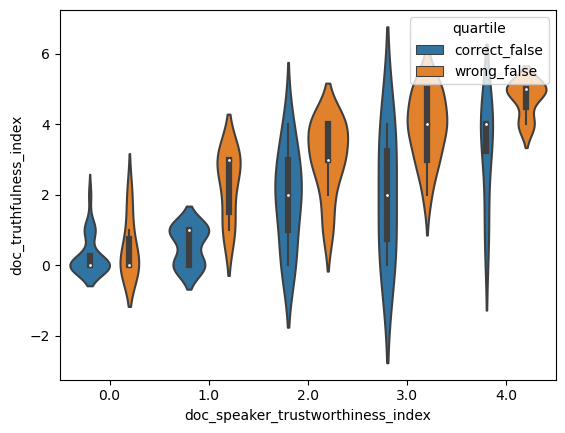

In [127]:
sns.violinplot(x="doc_speaker_trustworthiness_index", y="doc_truthfulness_index",hue="quartile", data=df_false[df_false["quartile"] != "other_false"])

In [128]:
df = df_wrong.groupby(["doc_accuracy_index","quartile"]).mean()["doc_truthfulness_index"]
df = df.reset_index(inplace=False)
df[df["quartile"] != "other_false"]

,doc_accuracy_index,quartile,doc_truthfulness_index
0,0.0,wrong_false,0.500000
1,0.0,wrong_true,0.500000
2,1.0,wrong_false,2.090909
3,1.0,wrong_true,0.800000
4,2.0,wrong_false,3.200000
5,2.0,wrong_true,2.928571
6,3.0,wrong_false,4.000000
7,3.0,wrong_true,3.461538
8,4.0,wrong_false,4.625000
9,4.0,wrong_true,4.416667


<Axes: xlabel='doc_accuracy_index', ylabel='doc_truthfulness_index'>

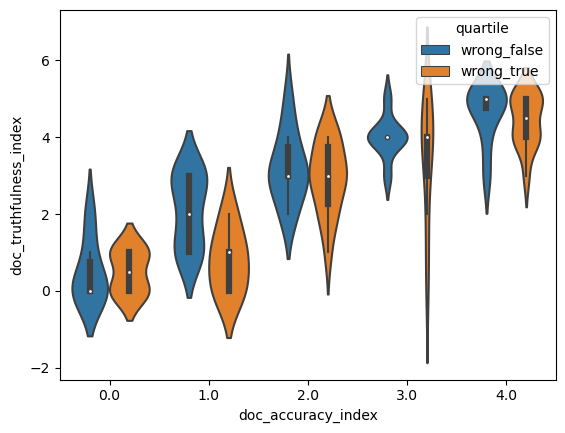

In [129]:
sns.violinplot(x="doc_accuracy_index", y="doc_truthfulness_index",hue="quartile", data=df_wrong[df_wrong["quartile"] != "other_false"])

<Axes: xlabel='doc_accuracy_index', ylabel='doc_truthfulness_index'>

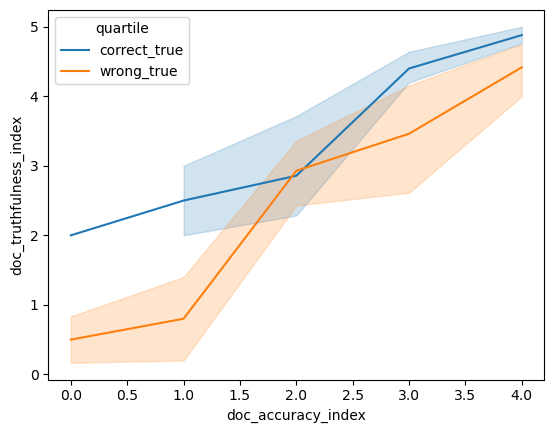

In [130]:
sns.lineplot(x="doc_accuracy_index", y="doc_truthfulness_index",hue="quartile", data=df_true[df_true["quartile"] != "other_true"])

In [131]:
df_all[["scarto", "doc_truthfulness_index","doc_fact_check_ground_truth_value"]]

,scarto,doc_truthfulness_index,doc_fact_check_ground_truth_value
0,0,4.0,4.0
1,0,1.0,1.0
2,1,1.0,0.0
3,2,1.0,3.0
4,2,4.0,2.0
...,...,...,...
1194,3,0.0,3.0
1195,1,0.0,1.0
1196,1,4.0,5.0
1197,3,5.0,2.0


In [132]:
df = df_true.groupby(["doc_accuracy_index","quartile"]).mean()["scarto"]
df = df.reset_index(inplace=False)
df[df["quartile"] != "other_true"]

,doc_accuracy_index,quartile,scarto
0,0.0,correct_true,3.000000
2,0.0,wrong_true,4.500000
3,1.0,correct_true,2.500000
5,1.0,wrong_true,4.200000
6,2.0,correct_true,2.142857
8,2.0,wrong_true,2.071429
9,3.0,correct_true,0.600000
11,3.0,wrong_true,1.538462
12,4.0,correct_true,0.120000
14,4.0,wrong_true,0.583333


,quartile,doc_speaker_trustworthiness_index
0,correct_false,1.100000
1,correct_true,2.833333
5,wrong_false,2.160000
6,wrong_true,1.960000


<Axes: xlabel='quartile', ylabel='doc_speaker_trustworthiness_index'>

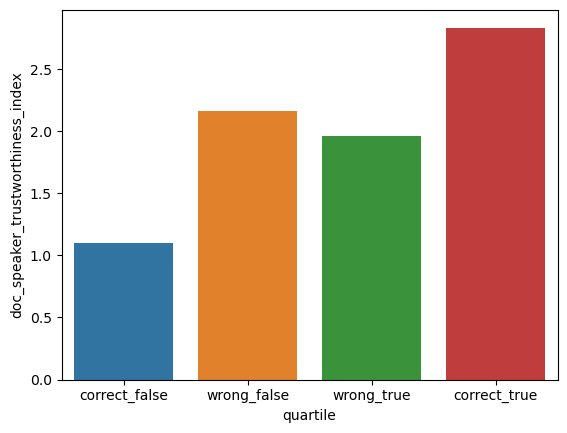

In [133]:
df = df_all.groupby(["quartile"]).mean()["doc_speaker_trustworthiness_index"]
df = df.reset_index(inplace=False)
df = df[(df["quartile"] != "other_true") & (df["quartile"] != "other_false") & (df["quartile"] != "other")]
df.sort_values(by="doc_speaker_trustworthiness_index", ascending=False)
display(df)
sns.barplot(x="quartile", y="doc_speaker_trustworthiness_index", data=df,order=["correct_false","wrong_false","wrong_true","correct_true"])

In [134]:
df_all[df_all["quartile"] == "correct_true"]["doc_speaker_name"].value_counts()

Democratic Party of Wisconsin    10
Levar Stoney                     10
Kathy Hochul                     10
Charlie Crist                    10
Abigail Spanberger               10
Andrew Yang                      10
Name: doc_speaker_name, dtype: int64

In [135]:
df = df_all.groupby(["quartile"]).mean()["doc_accuracy_index"]
df = df.reset_index(inplace=False)
df = df[(df["quartile"] != "other_true") & (df["quartile"] != "other_false") & (df["quartile"] != "other")]
df.sort_values(by="doc_accuracy_index", ascending=False)

,quartile,doc_accuracy_index
1,correct_true,3.183333
6,wrong_true,2.400000
5,wrong_false,2.160000
0,correct_false,1.120000


<Axes: xlabel='quartile', ylabel='doc_accuracy_index'>

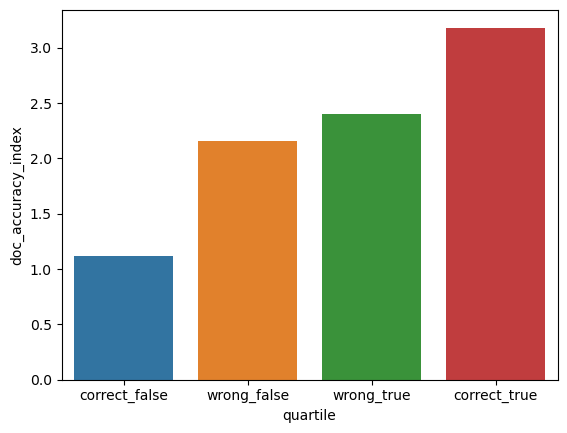

In [136]:
sns.barplot(x="quartile", y="doc_accuracy_index", data=df, order=["correct_false","wrong_false","wrong_true","correct_true"])

,quartile,scarto,doc_accuracy_index
0,correct_false,1.000000,1.120000
1,correct_true,0.683333,3.183333


<Axes: xlabel='quartile', ylabel='doc_accuracy_index'>

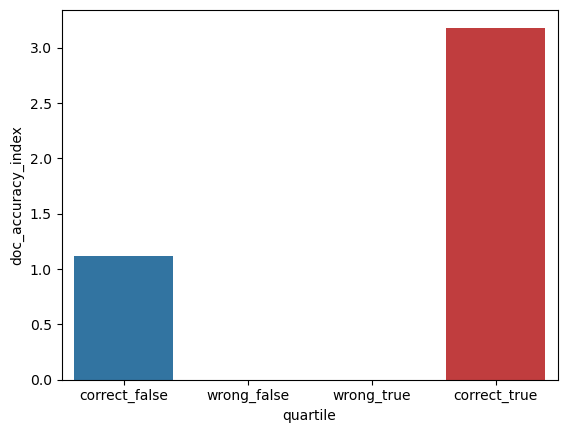

In [137]:
df = df_correct.groupby(["quartile"]).mean()[["scarto","doc_accuracy_index"]]
df = df.reset_index(inplace=False)
df = df[(df["quartile"] != "other_true") & (df["quartile"] != "other_false") & (df["quartile"] != "other")]
df.sort_values(by="doc_accuracy_index", ascending=False)
display(df)
sns.barplot(x="quartile", y="doc_accuracy_index", data=df,order=["correct_false","wrong_false","wrong_true","correct_true"])

In [138]:
for variabile_interesse in ["doc_truthfulness_index"]:
    for df in [["df_false",df_false], ["df_true",df_true]]:
        
        
        results = ols(
            f'''
                {variabile_interesse} ~ doc_accuracy_index+doc_speaker_trustworthiness_index """
            '''
            , data=df[1]).fit()
        aov_table = sm.stats.anova_lm(results, typ=2)
        anova_table_v = anova_table(aov_table)
        if anova_table_v["omega_sq"].max() > 0:
            print("-" * 100)
            print(f"""{variabile_interesse} ~ doc_accuracy_index+doc_speaker_trustworthiness_index in {df[0]}""")
            display(anova_table_v.sort_values(by="omega_sq", ascending=False))
            
        for index, row in anova_table_v.iterrows():
            if row["omega_sq"] > 0.14:
                print(index)
                tukey_results = pairwise_tukeyhsd(endog=df[1][variabile_interesse], 
                                        groups=df[1][index], 
                                        alpha=0.05)
                
                df_turkey = pd.DataFrame(data=tukey_results._results_table.data[1:], columns=tukey_results._results_table.data[0])
                display(df_turkey[df_turkey["reject"] == True].sort_values(by="p-adj", ascending=True))

----------------------------------------------------------------------------------------------------
doc_truthfulness_index ~ doc_accuracy_index+doc_speaker_trustworthiness_index in df_false


,sum_sq,df,mean_sq,F,PR(>F),eta_sq,omega_sq
doc_speaker_trustworthiness_index,49.762731,1.0,49.762731,40.991004,1.105929e-09,0.161395,0.156840
doc_accuracy_index,20.623409,1.0,20.623409,16.988100,5.549142e-05,0.066888,0.062704
Residual,237.942338,196.0,1.213992,NaN,NaN,NaN,NaN


doc_speaker_trustworthiness_index


,group1,group2,meandiff,p-adj,lower,upper,reject
1,0.0,2.0,2.1519,0.0000,1.5498,2.7539,True
2,0.0,3.0,3.1361,0.0000,2.4552,3.8170,True
3,0.0,4.0,3.4391,0.0000,2.6567,4.2216,True
5,1.0,3.0,2.0528,0.0000,1.2928,2.8128,True
6,1.0,4.0,2.3558,0.0000,1.5036,3.2081,True
0,0.0,1.0,1.0833,0.0001,0.4150,1.7516,True
8,2.0,4.0,1.2873,0.0002,0.4859,2.0886,True
4,1.0,2.0,1.0686,0.0003,0.3783,1.7589,True
7,2.0,3.0,0.9842,0.0014,0.2817,1.6867,True


----------------------------------------------------------------------------------------------------
doc_truthfulness_index ~ doc_accuracy_index+doc_speaker_trustworthiness_index in df_true


,sum_sq,df,mean_sq,F,PR(>F),eta_sq,omega_sq
doc_accuracy_index,81.179638,1.0,81.179638,97.000752,7.298248e-19,0.317308,0.313013
doc_speaker_trustworthiness_index,9.790213,1.0,9.790213,11.698230,7.604361e-04,0.038267,0.034882
Residual,164.868708,197.0,0.836897,NaN,NaN,NaN,NaN


doc_accuracy_index


,group1,group2,meandiff,p-adj,lower,upper,reject
2,0.0,3.0,2.5235,0.0000,1.7388,3.3083,True
3,0.0,4.0,3.2682,0.0000,2.4895,4.0469,True
5,1.0,3.0,2.0565,0.0000,1.2956,2.8174,True
6,1.0,4.0,2.8012,0.0000,2.0465,3.5558,True
7,2.0,3.0,1.0788,0.0000,0.5224,1.6353,True
8,2.0,4.0,1.8235,0.0000,1.2756,2.3713,True
9,3.0,4.0,0.7447,0.0000,0.3080,1.1813,True
1,0.0,2.0,1.4447,0.0001,0.5931,2.2964,True
4,1.0,2.0,0.9777,0.0120,0.1479,1.8074,True


- Con i statement FALSE ha più importanza la doc_speaker_trustworthiness_index
- Con i statement TRUE ha più importanza la doc_accuracy_index

### Analizzo doc_accuracy_index

In [139]:
df = df_true.groupby(["doc_accuracy_index","quartile"]).mean()["doc_truthfulness_index"]
df = df.reset_index(inplace=False)
df[df["quartile"] != "other_true"].sort_values(by="quartile", ascending=False)

,doc_accuracy_index,quartile,doc_truthfulness_index
2,0.0,wrong_true,0.500000
5,1.0,wrong_true,0.800000
8,2.0,wrong_true,2.928571
11,3.0,wrong_true,3.461538
14,4.0,wrong_true,4.416667
0,0.0,correct_true,2.000000
3,1.0,correct_true,2.500000
6,2.0,correct_true,2.857143
9,3.0,correct_true,4.400000
12,4.0,correct_true,4.880000


In [140]:
df = df_correct.groupby(["doc_accuracy_index","quartile"]).mean()["doc_truthfulness_index"]
df = df.reset_index(inplace=False)
df[df["quartile"] != "other_true"].sort_values(by="quartile", ascending=False)

,doc_accuracy_index,quartile,doc_truthfulness_index
1,0.0,correct_true,2.000000
3,1.0,correct_true,2.500000
5,2.0,correct_true,2.857143
7,3.0,correct_true,4.400000
9,4.0,correct_true,4.880000
0,0.0,correct_false,0.166667
2,1.0,correct_false,0.818182
4,2.0,correct_false,2.000000
6,3.0,correct_false,3.285714
8,4.0,correct_false,1.500000


In [141]:
df = df_wrong.groupby(["doc_accuracy_index","quartile"]).mean()["doc_truthfulness_index"]
df = df.reset_index(inplace=False)
df[df["quartile"] != "other_true"].sort_values(by="quartile", ascending=False)

,doc_accuracy_index,quartile,doc_truthfulness_index
1,0.0,wrong_true,0.500000
3,1.0,wrong_true,0.800000
5,2.0,wrong_true,2.928571
7,3.0,wrong_true,3.461538
9,4.0,wrong_true,4.416667
0,0.0,wrong_false,0.500000
2,1.0,wrong_false,2.090909
4,2.0,wrong_false,3.200000
6,3.0,wrong_false,4.000000
8,4.0,wrong_false,4.625000


In [142]:
for variabile_interesse in ["wrong_true","correct_true","correct"]:
    for df in [["df_wrong",df_wrong], ["df_correct",df_correct], ["df_all",df_all], ["df_true",df_true], ["df_false",df_false]]:
        
        
        results = ols(
            f'''
                {variabile_interesse} ~ doc_accuracy_index """
            '''
            , data=df[1]).fit()
        aov_table = sm.stats.anova_lm(results, typ=2)
        anova_table_v = anova_table(aov_table)
        if anova_table_v["omega_sq"].max() > 0.14:
            print("-" * 100)
            print(f"""{variabile_interesse} ~ doc_accuracy_index in {df[0]}""")
            display(anova_table_v.sort_values(by="omega_sq", ascending=False))
            
        for index, row in anova_table_v.iterrows():
            if row["omega_sq"] > 0.14:
                print(index)
                tukey_results = pairwise_tukeyhsd(endog=df[1][variabile_interesse], 
                                        groups=df[1][index], 
                                        alpha=0.05)
                
                df_turkey = pd.DataFrame(data=tukey_results._results_table.data[1:], columns=tukey_results._results_table.data[0])
                display(df_turkey[df_turkey["reject"] == True].sort_values(by="p-adj", ascending=True))

----------------------------------------------------------------------------------------------------
correct_true ~ doc_accuracy_index in df_correct


,sum_sq,df,mean_sq,F,PR(>F),eta_sq,omega_sq
doc_accuracy_index,12.448740,1.0,12.448740,90.695156,5.658630e-16,0.456454,0.44916
Residual,14.823988,108.0,0.137259,NaN,NaN,NaN,NaN


doc_accuracy_index


,group1,group2,meandiff,p-adj,lower,upper,reject
2,0.0,3.0,0.7412,0.0000,0.4696,1.0129,True
3,0.0,4.0,0.8221,0.0000,0.5443,1.0998,True
5,1.0,3.0,0.6274,0.0000,0.2927,0.9621,True
6,1.0,4.0,0.7082,0.0000,0.3685,1.0479,True
1,0.0,2.0,0.5964,0.0002,0.2281,0.9646,True
4,1.0,2.0,0.4825,0.0148,0.0656,0.8994,True


In [143]:
df_all[["doc_truthfulness_index","quartile"]]

,doc_truthfulness_index,quartile
0,4.0,other
1,1.0,other
2,1.0,correct_false
3,1.0,other
4,4.0,other
...,...,...
1194,0.0,other
1195,0.0,other
1196,4.0,wrong_true
1197,5.0,other


### Rapporto tra frequenze relative

In [144]:
raccoglitore_dimensioni = crea_raccoglitore_dimensioni(df_all, dimensioni_da_analizzare, quartili)
tabella_p_value = costruisci_tabella_pvalue(raccoglitore_dimensioni, dimensioni_da_analizzare, quartili)
significativi = filtra_siglificativi(tabella_p_value, dimensioni_da_analizzare, quartili, 0.05,"pvalue_quartile_sovra").sort_values(by=["dimensione"], ascending=True)
significativi

,dimensione,quartile,confronto,valore_pvalue,p_trend
35,doc_accuracy_index,wrong_true,pvalue_quartile_sovra,0.006909,0.139326
33,doc_accuracy_index,correct_false,pvalue_quartile_sovra,0.013714,0.078780
30,doc_accuracy_index,wrong_false,pvalue_quartile_sovra,0.017761,0.536334
7,doc_comprehensibility_index,wrong_true,pvalue_quartile_sovra,0.046483,0.023365
50,doc_confidence_index,correct_false,pvalue_quartile_sovra,0.025301,0.067685
51,doc_confidence_index,wrong_true,pvalue_quartile_sovra,0.029073,0.020806
15,doc_informativeness_index,wrong_false,pvalue_quartile_sovra,0.002372,0.059583
19,doc_informativeness_index,wrong_true,pvalue_quartile_sovra,0.045200,0.016200
11,doc_precision_index,wrong_true,pvalue_quartile_sovra,0.044595,0.091103
44,doc_speaker_trustworthiness_index,wrong_true,pvalue_quartile_sovra,0.000084,0.717686


In [145]:
upper_pvalue = {}
for dimensione in dimensioni_da_analizzare:
    upper_pvalue[dimensione] = {}
    for quartile in quartili:
        upper_pvalue[dimensione][quartile] = False

# in alto
add_line = False
for dimensione in dimensioni_da_analizzare:
    for quartile in quartili:
        if add_line:
            print("\n")
            add_line = False

        for A in raccoglitore_dimensioni[dimensione][quartile]["valore"]:
            for B in raccoglitore_dimensioni[dimensione][quartile]["valore"]:
                if A != B:
                    successes = [raccoglitore_dimensioni[dimensione][quartile][raccoglitore_dimensioni[dimensione][quartile]["valore"] == A]["freq_ass_quartile"], 
                                raccoglitore_dimensioni[dimensione][quartile][raccoglitore_dimensioni[dimensione][quartile]["valore"] == B]["freq_ass_quartile"]]
                    totals = [raccoglitore_dimensioni[dimensione][quartile][raccoglitore_dimensioni[dimensione][quartile]["valore"] == A]["freq_ass_sovra"], 
                            raccoglitore_dimensioni[dimensione][quartile][raccoglitore_dimensioni[dimensione][quartile]["valore"] == B]["freq_ass_sovra"]]

                    (chi2, p, arr) = ssp.proportions_chisquare(successes, totals)
                    if p < 0.05:
                        print(dimensione,"|",quartile,"|",A,"vs",B,"|","pvalue:",p)
                        add_line = True
                        upper_pvalue[dimensione][quartile] = True


doc_completeness_index | wrong_true | 0.0 vs 3.0 | pvalue: 0.033668870450073995
doc_completeness_index | wrong_true | 0.0 vs 4.0 | pvalue: 0.007585377205587148
doc_completeness_index | wrong_true | 3.0 vs 0.0 | pvalue: 0.033668870450073995
doc_completeness_index | wrong_true | 4.0 vs 0.0 | pvalue: 0.007585377205587145


doc_completeness_index | correct_true | 1.0 vs 3.0 | pvalue: 0.033048155385381826
doc_completeness_index | correct_true | 3.0 vs 1.0 | pvalue: 0.03304815538538184


doc_comprehensibility_index | wrong_true | 0.0 vs 4.0 | pvalue: 0.03819365957863395
doc_comprehensibility_index | wrong_true | 3.0 vs 4.0 | pvalue: 0.03216673298513569
doc_comprehensibility_index | wrong_true | 4.0 vs 0.0 | pvalue: 0.038193659578633875
doc_comprehensibility_index | wrong_true | 4.0 vs 3.0 | pvalue: 0.03216673298513569


doc_precision_index | correct_false | 0.0 vs 1.0 | pvalue: 0.03565126410886268
doc_precision_index | correct_false | 0.0 vs 3.0 | pvalue: 0.03831042444051757
doc_precision_in

In [146]:
inner_pvalue = {}
for dimensione in dimensioni_da_analizzare:
    inner_pvalue[dimensione] = {}
    for val in raccoglitore_dimensioni[dimensione]["wrong_false"]["valore"]:
        inner_pvalue[dimensione][val] = False

# vicino a ogni label
add_line = False
for dimensione in dimensioni_da_analizzare:
    for label in raccoglitore_dimensioni[dimensione]["wrong_false"]["valore"]:
        if add_line:
            print("\n")
            add_line = False
        for q1 in quartili:
            for q2 in quartili:
                if q1 != q2:
                    successes = [raccoglitore_dimensioni[dimensione][q1][raccoglitore_dimensioni[dimensione][q1]["valore"] == label]["freq_ass_quartile"], 
                                raccoglitore_dimensioni[dimensione][q2][raccoglitore_dimensioni[dimensione][q2]["valore"] == label]["freq_ass_quartile"]]
                    totals = [raccoglitore_dimensioni[dimensione][q1][raccoglitore_dimensioni[dimensione][q1]["valore"] == label]["freq_ass_sovra"], 
                            raccoglitore_dimensioni[dimensione][q2][raccoglitore_dimensioni[dimensione][q2]["valore"] == label]["freq_ass_sovra"]]

                    (chi2, p, arr) = ssp.proportions_chisquare(successes, totals)
                    if p < 0.05:
                        print(dimensione,"|", label,"|", q1,"vs",q2,"|","pvalue:",p)
                        add_line = True
                        inner_pvalue[dimensione][label] = True

doc_completeness_index | 0.0 | wrong_false vs wrong_true | pvalue: 0.007373938701434857
doc_completeness_index | 0.0 | wrong_true vs wrong_false | pvalue: 0.007373938701434857


doc_completeness_index | 4.0 | wrong_true vs correct_true | pvalue: 0.03462880330565622
doc_completeness_index | 4.0 | correct_true vs wrong_true | pvalue: 0.03462880330565622


doc_comprehensibility_index | 0.0 | wrong_false vs wrong_true | pvalue: 0.04722090400357733
doc_comprehensibility_index | 0.0 | wrong_true vs wrong_false | pvalue: 0.04722090400357733


doc_comprehensibility_index | 4.0 | wrong_true vs correct_true | pvalue: 0.003507384799290081
doc_comprehensibility_index | 4.0 | correct_true vs wrong_true | pvalue: 0.003507384799290081


doc_precision_index | 0.0 | wrong_false vs correct_false | pvalue: 0.013184374974836977
doc_precision_index | 0.0 | correct_false vs wrong_false | pvalue: 0.013184374974836977


doc_precision_index | 1.0 | correct_false vs wrong_true | pvalue: 0.02721144586812069
doc_

In [147]:
from matplotlib.colors import to_rgba

def crea_barplot_all_rapporto(raccoglitore_dimensioni,upper_pvalue,inner_pvalue,dimensione,valore,rotation = None,inverted_axes = False):

    fig, ax = plt.subplots(ncols=4, figsize=(10,4), sharey=True, sharex=True)

    #fig.suptitle(dimensione, fontsize=16, fontweight=0, color='black', y=1.09)
    
    if valore == "label":
        fig.tight_layout(h_pad=10, w_pad=5)
    else:
        fig.tight_layout(pad=8.5)
    
    for quartile in quartili:
        
                
        if quartile == "wrong_false":
            i = 0
        elif quartile == "wrong_true":
            i = 1
        elif quartile == "correct_false":
            i = 2
        elif quartile == "correct_true":
            i = 3
       
       
        labels = []
        for label in raccoglitore_dimensioni[dimensione][quartile]["valore"]:    
            if inner_pvalue[dimensione][label]:
                
                labels.append(
                    str(label) + "\np < 0.05"
                    ) 
            else:
                labels.append(str(label) + "\np >= 0.05")
       
        sub_freq_rel = {
            "valore" : labels,
            "frequenza" : raccoglitore_dimensioni[dimensione][quartile]["rapporto"]
        }
        
        
        ax[i].grid(alpha=0.4)
        
       
       
        if inverted_axes:
            # orrizzontale  
            sns.barplot(data=sub_freq_rel, y = "valore", x = "frequenza", ax = ax[i], orient="h",palette = "Blues_d")   
            ax[i].set( ylabel=None, xlabel = None)
            

        else:
            #verticale
            #sns.barplot(data=sub_freq_rel, y = "frequenza", x = "valore", hue ="colonna", ax=ax[i,j], palette=["g","indianred", "goldenrod"]) 
            sns.barplot(data=sub_freq_rel, y = "frequenza", x = "valore", palette = "Blues_d",ax=ax[i])
            ax[i].set( ylabel=None, xlabel = None)
        ax[i].bar_label(ax[i].containers[0], fmt='%.1f')
        
        if upper_pvalue[dimensione][quartile] == True:
            
            ax[i].text(0.5, 1.08, "p-value " + "<= 0.05"
                            , transform=ax[i].transAxes, fontsize=9, fontweight=0, color='red', va='top', ha='center')
            ax[i].set_title(quartile,loc="center", fontsize=11, fontweight=0, color='red', y=1.09)
            
        else:
            ax[i].text(0.5, 1.08, "p-value " + ">= 0.05"
                            , transform=ax[i].transAxes, fontsize=9, fontweight=0, color='black', va='top', ha='center')
            ax[i].set_title(quartile,loc="center", fontsize=11, fontweight=0, color='black', y=1.09)
                        
        
        
    
    print("\centering\n\\begin{subfigure}{.85\linewidth}\n\centering")    
    print("\includegraphics[width=\linewidth]{tesi/media/new/rapporto_"+dimensione+".png}\n\caption{Analisi frequenze relative della dimensione " + dimensione[:-6]+"}\n\label{cap:frequenze_relative_" + dimensione[:-6] + "}")
    print("\end{subfigure}")
    
    plt.savefig("plots/rapporto_"+dimensione+".png", dpi=500, bbox_inches='tight')  
    #plt.show()


In [148]:
for dimensione in dimensioni_da_analizzare:
    for quartile in quartili:
        raccoglitore_dimensioni[dimensione][quartile]
        r = []
        for row in raccoglitore_dimensioni[dimensione][quartile].iterrows():
            r.append(row[1]["freq_rel_quartile"]/row[1]["freq_rel_sovra"])
        raccoglitore_dimensioni[dimensione][quartile]["rapporto"] = r

\begin{figure}[htbp]
\centering
\begin{subfigure}{.85\linewidth}
\centering
\includegraphics[width=\linewidth]{tesi/media/new/rapporto_doc_completeness_index.png}
\caption{Analisi frequenze relative della dimensione doc_completeness}
\label{cap:frequenze_relative_doc_completeness}
\end{subfigure}
\centering
\begin{subfigure}{.85\linewidth}
\centering
\includegraphics[width=\linewidth]{tesi/media/new/rapporto_doc_comprehensibility_index.png}
\caption{Analisi frequenze relative della dimensione doc_comprehensibility}
\label{cap:frequenze_relative_doc_comprehensibility}
\end{subfigure}
\centering
\begin{subfigure}{.85\linewidth}
\centering
\includegraphics[width=\linewidth]{tesi/media/new/rapporto_doc_precision_index.png}
\caption{Analisi frequenze relative della dimensione doc_precision}
\label{cap:frequenze_relative_doc_precision}
\end{subfigure}
\centering
\begin{subfigure}{.85\linewidth}
\centering
\includegraphics[width=\linewidth]{tesi/media/new/rapporto_doc_informativeness_index.pn

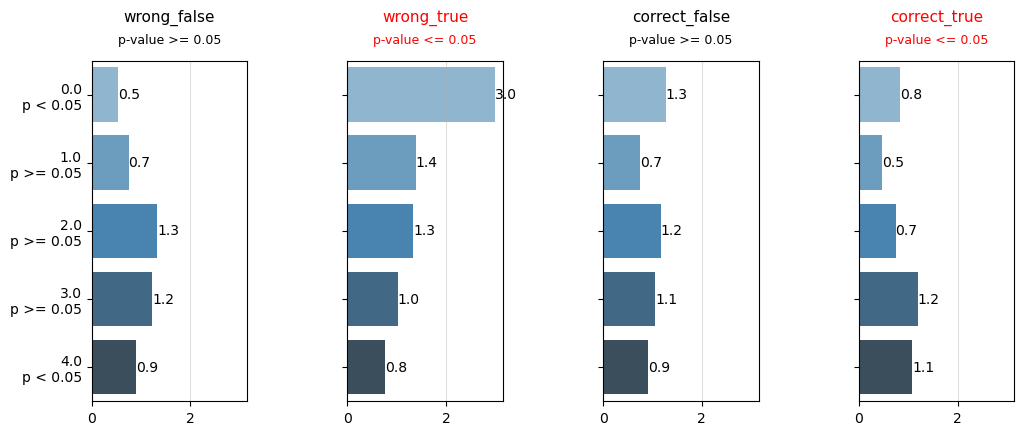

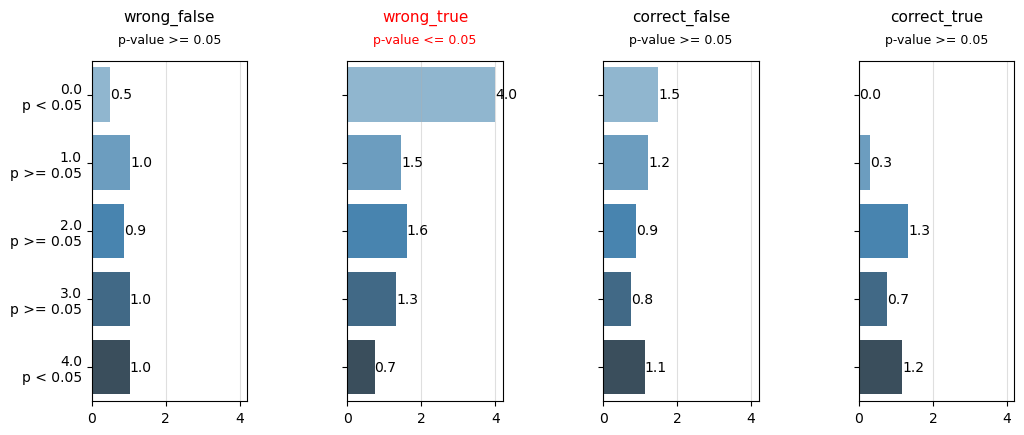

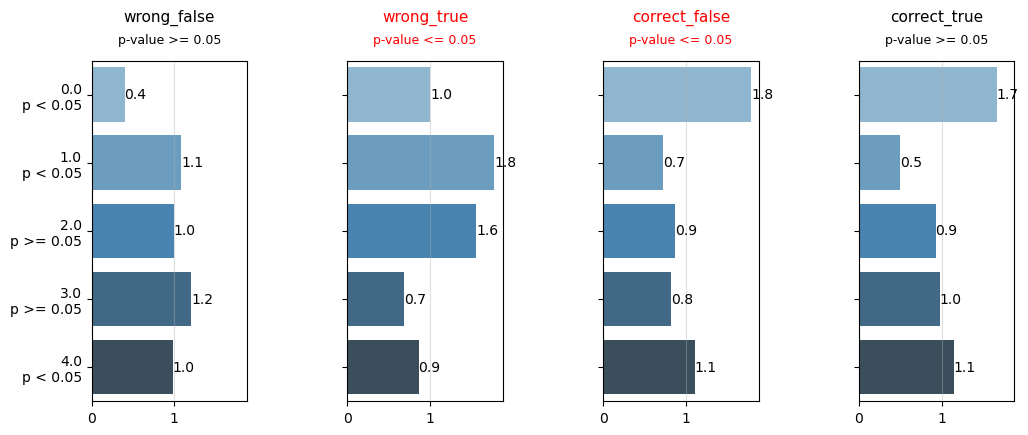

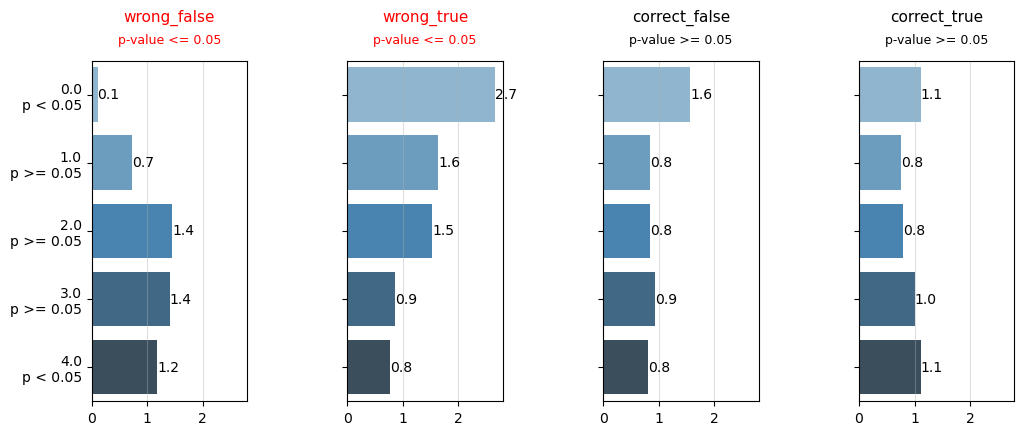

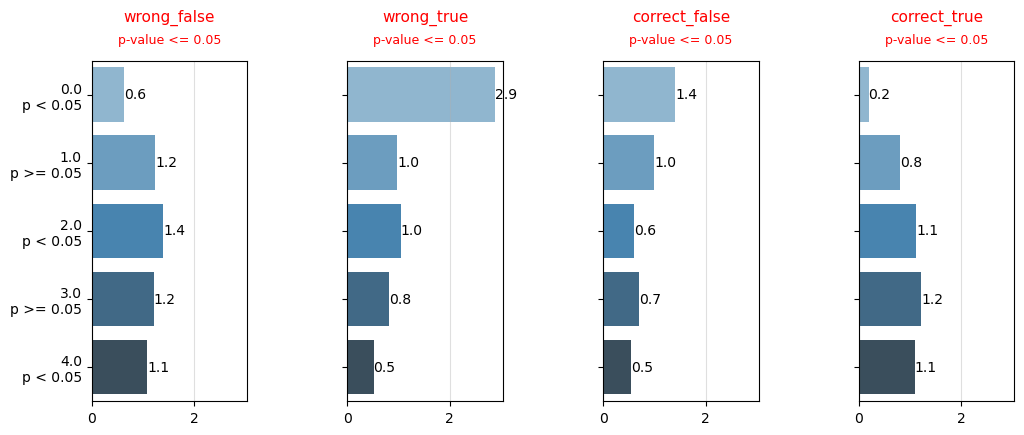

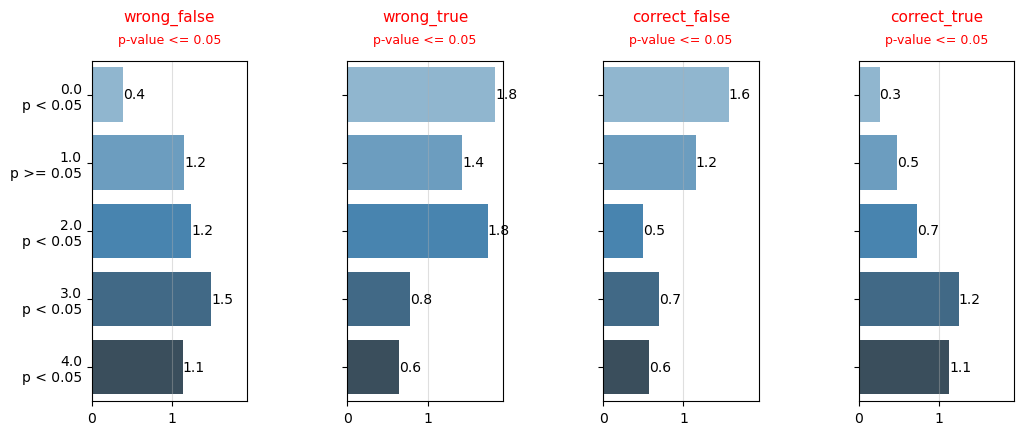

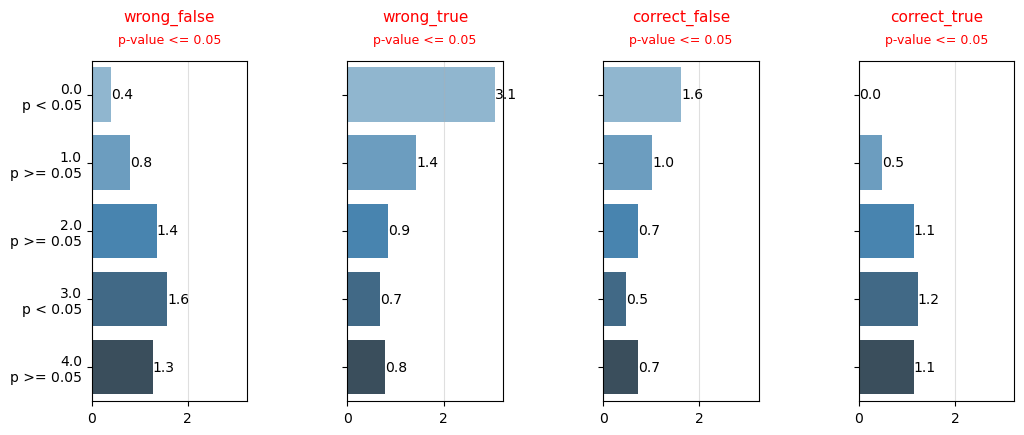

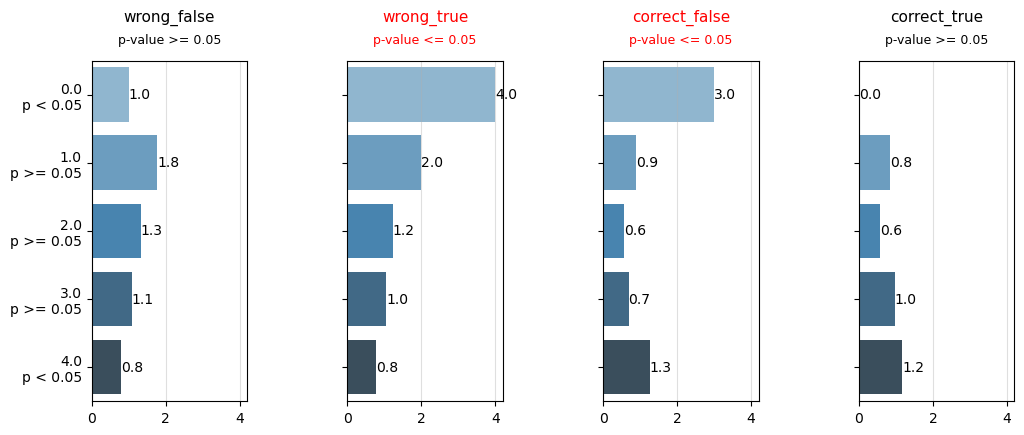

In [149]:
print("\\begin{figure}[htbp]")
for dimensione in dimensioni_da_analizzare:
    crea_barplot_all_rapporto(raccoglitore_dimensioni,upper_pvalue,inner_pvalue, dimensione,"label",inverted_axes = True)
print("\caption{TESTO}\n\end{figure}")

In [150]:
# solo significativi
#for dimensione in significativi["dimensione"].unique():
#    crea_barplot_all_anova(raccoglitore_dimensioni,tabella_p_value, dimensione,"valore")

## COnfronto gruppi

In [151]:
raccoglitore_dimensioni["doc_accuracy_index"]["correct_false"]

,valore,freq_ass_all,freq_ass_sovra,freq_ass_quartile,freq_rel_all,freq_rel_sovra,freq_rel_quartile,rapporto
3,0.0,217,61,24,0.180984,0.306533,0.48,1.565902
1,1.0,215,38,11,0.179316,0.190955,0.22,1.152105
2,2.0,198,32,4,0.165138,0.160804,0.08,0.497500
0,3.0,325,40,7,0.271059,0.201005,0.14,0.696500
4,4.0,244,28,4,0.203503,0.140704,0.08,0.568571


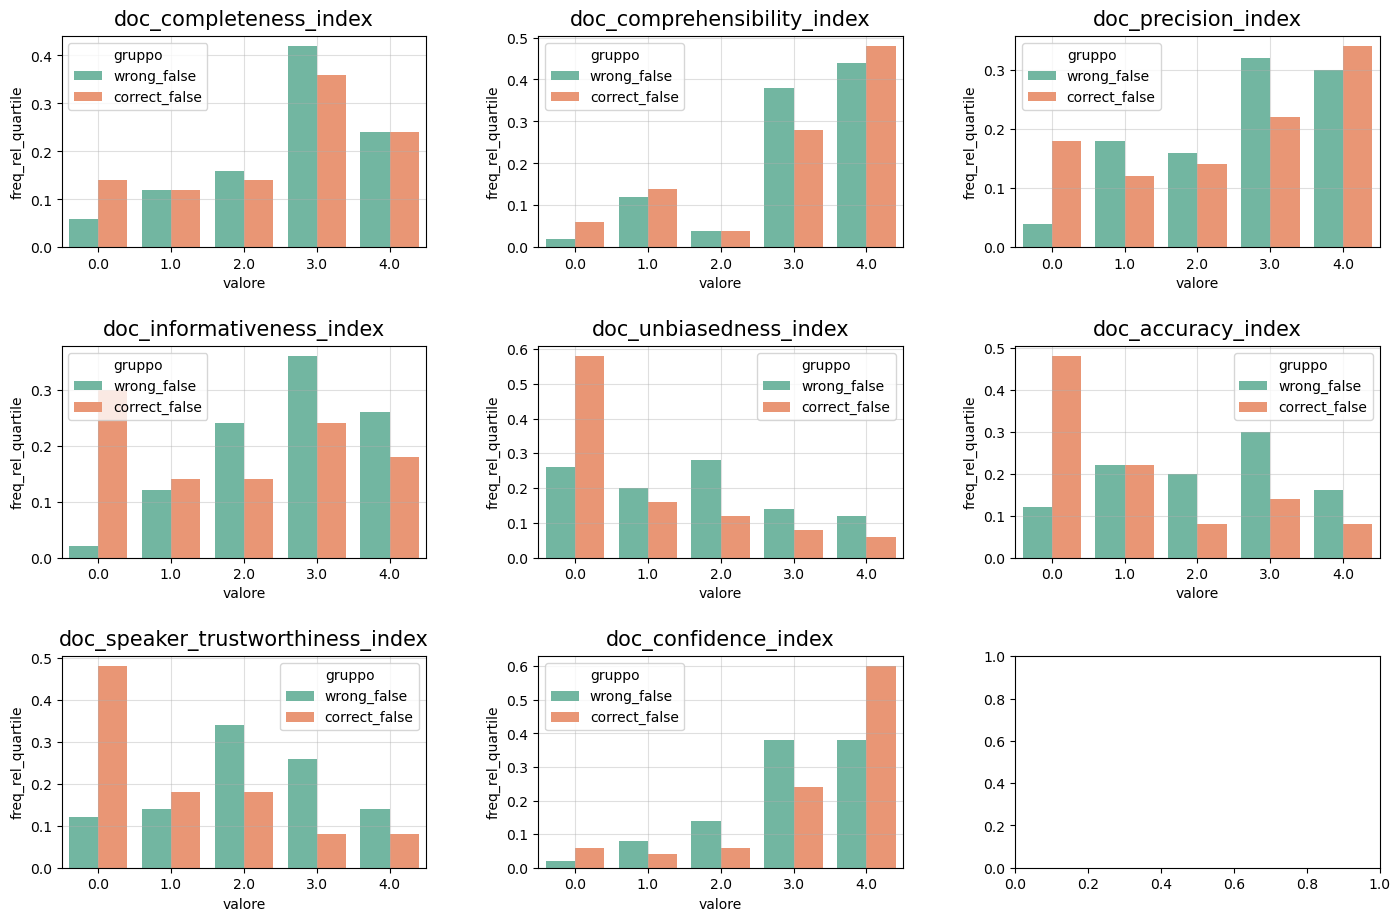

In [152]:
gruppo = ["wrong_false", "correct_false"]
crea_barplot_gruppi_quartili(raccoglitore_dimensioni,dimensioni_da_analizzare,gruppo,label=False)

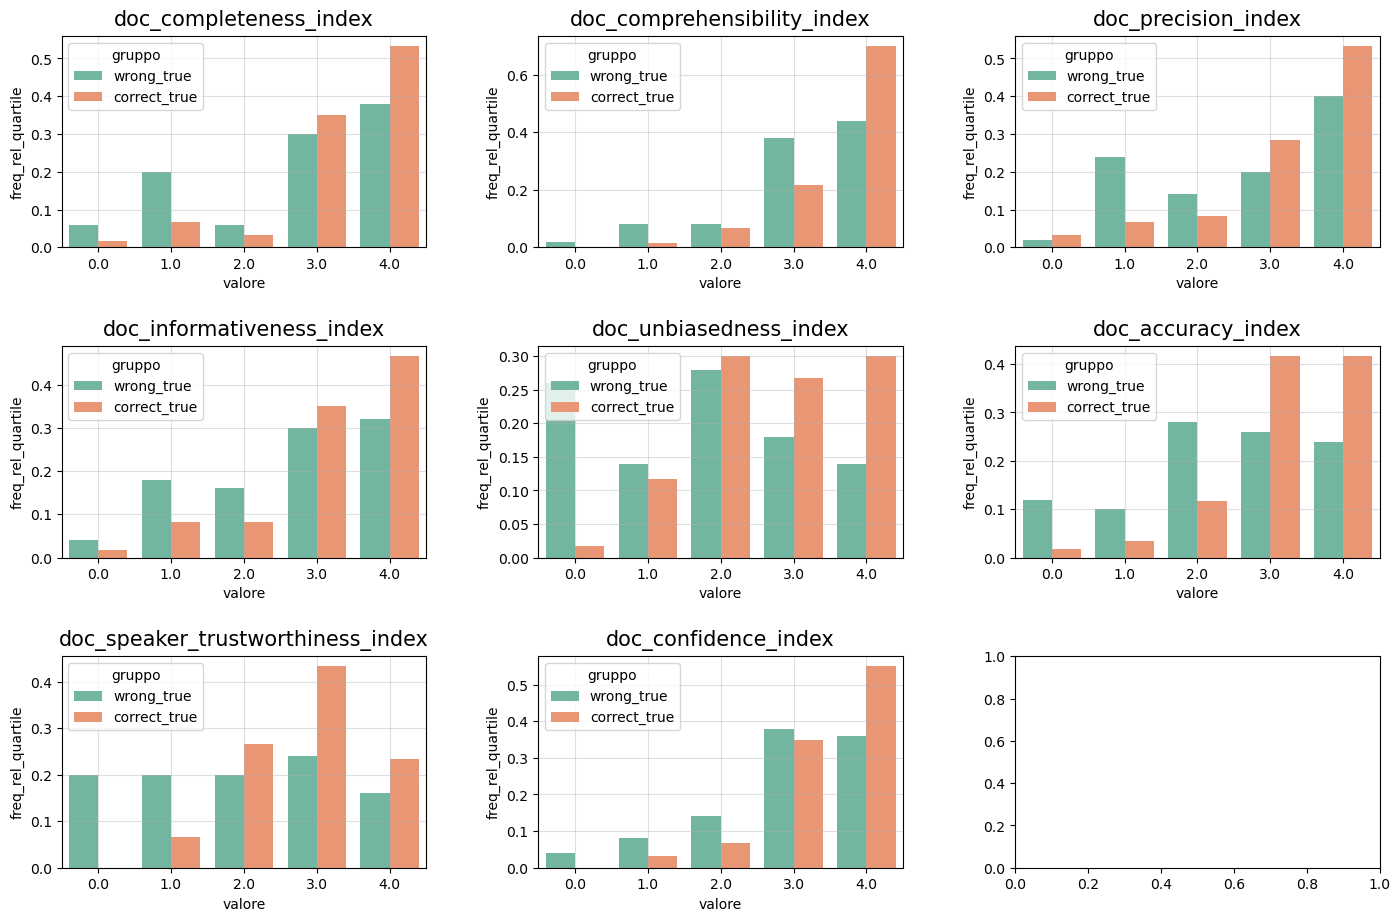

In [153]:
gruppo = ["wrong_true", "correct_true"]
crea_barplot_gruppi_quartili(raccoglitore_dimensioni,dimensioni_da_analizzare,gruppo,label=False)

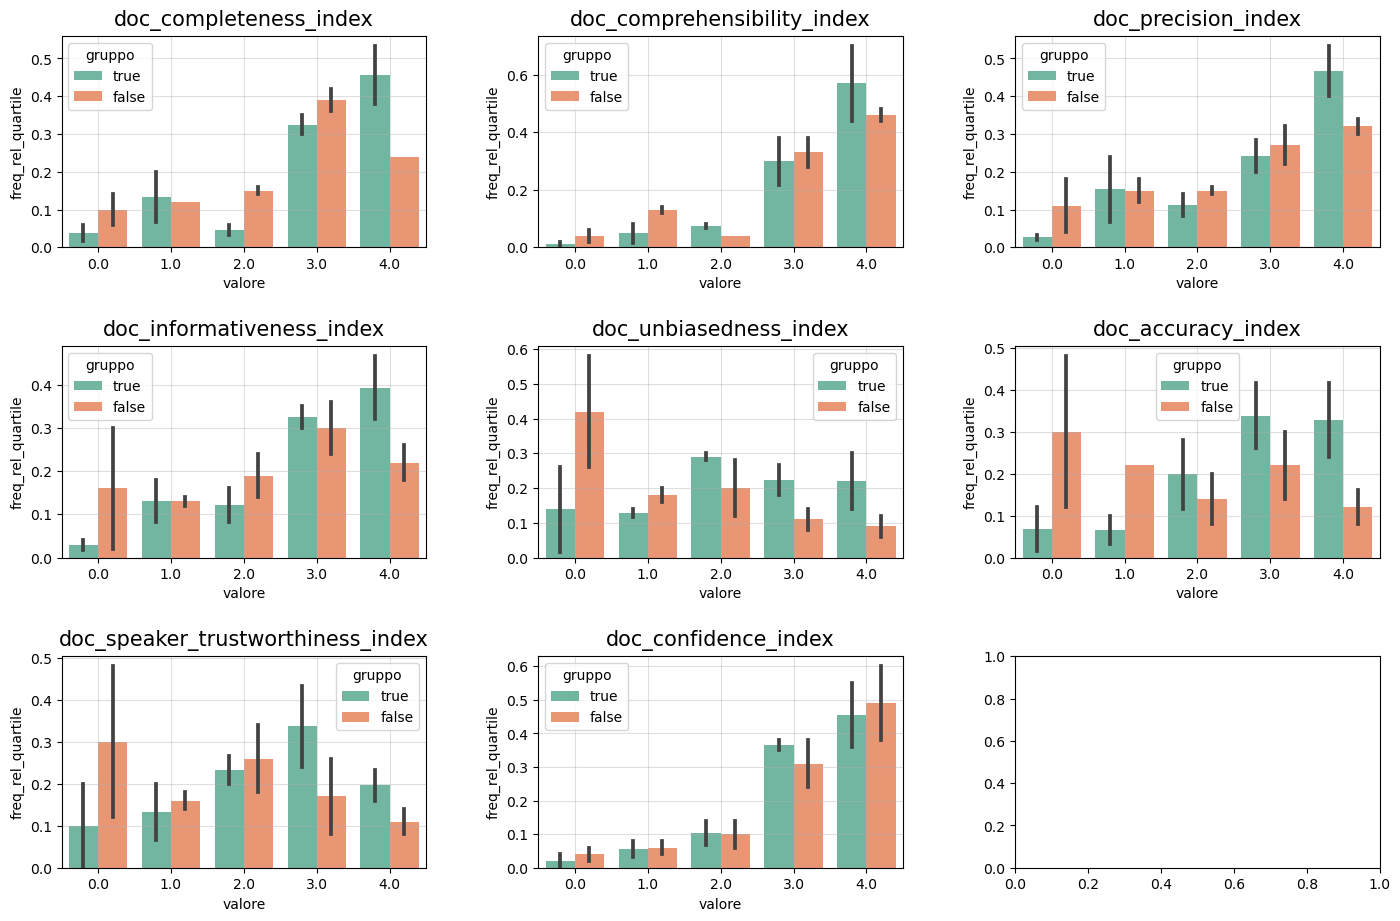

In [154]:
gruppo = [["wrong_true", "correct_true"],["wrong_false", "correct_false"]]
crea_barplot_gruppi_quartili(raccoglitore_dimensioni,dimensioni_da_analizzare,gruppo,label = False,names = ["true","false"])

In [155]:
gruppi_quartili = [["correct_true", "wrong_true"],["wrong_false", "correct_false"]]
name_gruppi = ["true","false"]
calcola_p_value_gruppi_quartili(raccoglitore_dimensioni, dimensioni_da_analizzare, gruppi_quartili,label = False, name_gruppi = name_gruppi, solo_significativi = True)

true doc_completeness_index 0.01551888902662775
false doc_completeness_index 0.010754339149312474
true doc_precision_index 0.01712140297472313
true doc_informativeness_index 0.017514878050111638
false doc_informativeness_index 0.02977444094426611
true doc_unbiasedness_index 0.00033173832353190774
false doc_unbiasedness_index 0.004979329604815454
true doc_accuracy_index 2.184129583904519e-06
false doc_accuracy_index 0.005247384831136464
true doc_speaker_trustworthiness_index 0.002613678585753478
false doc_speaker_trustworthiness_index 0.019706409021489426


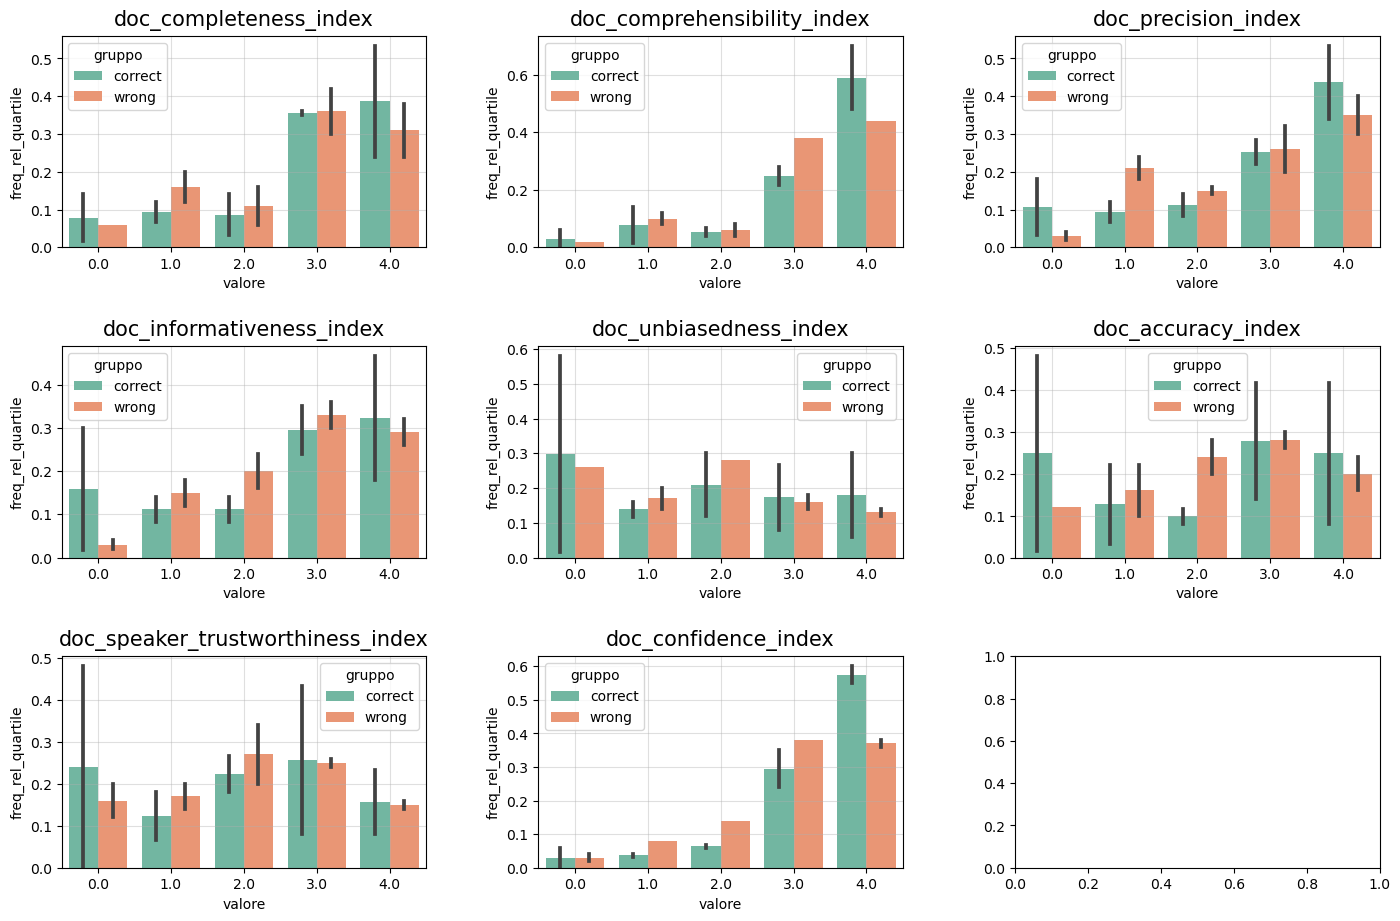

In [156]:
gruppo = [["correct_false", "correct_true"],["wrong_false", "wrong_true"]]
crea_barplot_gruppi_quartili(raccoglitore_dimensioni,dimensioni_da_analizzare,gruppo,label = False,names = ["correct","wrong"])

In [157]:
gruppi_quartili = [["correct_false", "correct_true"],["wrong_false", "wrong_true"]]
name_gruppi = ["correct","wrong"]
calcola_p_value_gruppi_quartili(raccoglitore_dimensioni, dimensioni_da_analizzare, gruppi_quartili,label = False, name_gruppi = name_gruppi, solo_significativi = True)

correct doc_precision_index 0.04461882853379541


## Analisi Scarto

In [158]:
analizza_scarto(df_all,quartili,dimensioni_da_analizzare,solo_quartile_vs_sovra = False)

quartile vs all =>  doc_precision_index correct_true -> 1.3819121346411106e-06
quartile vs all =>  doc_informativeness_index correct_false -> 0.012350119551602505
quartile vs all =>  doc_informativeness_index correct_true -> 0.018702064613343724
quartile vs all =>  doc_unbiasedness_index correct_true -> 4.5622484945204806e-09
quartile vs all =>  doc_confidence_index correct_false -> 1.028309431426172e-09


## Regressione

In [159]:
dimensioni_da_analizzare = dimensioni_da_analizzare + ["doc_time_elapsed"]

In [160]:
df_all_con_medie = df_all.copy()

calcolo per ogni doc id la sua media per ciascun valore

In [161]:
for dimensione in dimensioni_da_analizzare:
    df_all_con_medie[dimensione[:-6]+"_mean"] = 0

for statement in df_all_con_medie["doc_id"].unique():
    for dim in dimensioni_da_analizzare:
        mean = np.asarray(df_all_con_medie[df_all_con_medie["doc_id"] == statement][dim],dtype = np.float64).mean()
        df_all_con_medie.loc[df_all_con_medie["doc_id"] == statement, dim[:-6]+"_mean"] = mean 

In [162]:
df_all_con_medie.drop_duplicates(subset = ["doc_id"], inplace = True)

In [163]:
df_all_con_medie[["mean","doc_accuracy_mean","doc_speaker_trustworthiness_mean"]]

,mean,doc_accuracy_mean,doc_speaker_trustworthiness_mean
0,3.4,2.5,1.9
1,1.4,1.0,1.1
2,1.2,1.8,1.2
3,2.6,1.8,1.8
4,2.7,2.3,2.5
...,...,...,...
423,2.3,1.9,2.1
424,2.5,2.1,1.7
426,4.1,3.5,2.8
432,4.2,3.0,2.7


In [164]:
corr, p_value = pearsonr(df_all_con_medie["doc_accuracy_index"], df_all_con_medie["doc_truthfulness_index"])
# Stampa i risultati
print(f"Coefficiente di correlazione: {corr}")
print(f"P-value: {p_value}")

Coefficiente di correlazione: 0.7892161926649186
P-value: 9.532831326019199e-27


In [165]:
for variabile_interesse in ["mean"]:
    for df in ["df_medie",df_all_con_medie]:
        
        
        results = ols(
            f'''
                {variabile_interesse} ~ doc_accuracy_mean + doc_speaker_trustworthiness_mean """
            '''
            , data=df[1]).fit()
        aov_table = sm.stats.anova_lm(results, typ=2)
        anova_table_v = anova_table(aov_table)
        if anova_table_v["omega_sq"].max() > 0.14:
            print("-" * 100)
            print(f"""{variabile_interesse} ~ doc_accuracy_mean + doc_speaker_trustworthiness_mean in {df[0]}""")
            display(anova_table_v.sort_values(by="omega_sq", ascending=False))
            
        for index, row in anova_table_v.iterrows():
            if row["omega_sq"] > 0.14:
                print(index)
                tukey_results = pairwise_tukeyhsd(endog=df[1][variabile_interesse], 
                                        groups=df[1][index], 
                                        alpha=0.05)
                
                df_turkey = pd.DataFrame(data=tukey_results._results_table.data[1:], columns=tukey_results._results_table.data[0])
                display(df_turkey[df_turkey["reject"] == True].sort_values(by="p-adj", ascending=True))

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "d:\Programs\anaconda3\envs\Env_ForTesi\lib\site-packages\patsy\compat.py", line 36, in call_and_wrap_exc
    return f(*args, **kwargs)
  File "d:\Programs\anaconda3\envs\Env_ForTesi\lib\site-packages\patsy\eval.py", line 169, in eval
    return eval(code, {}, VarLookupDict([inner_namespace]
  File "<string>", line 1, in <module>
  File "d:\Programs\anaconda3\envs\Env_ForTesi\lib\site-packages\patsy\eval.py", line 52, in __getitem__
    return d[key]
  File "d:\Programs\anaconda3\envs\Env_ForTesi\lib\site-packages\patsy\eval.py", line 52, in __getitem__
    return d[key]
TypeError: string indices must be integers

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "d:\Programs\anaconda3\envs\Env_ForTesi\lib\site-packages\IPython\core\interactiveshell.py", line 3460, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\gabri\AppData\Local\Temp\ipykernel_14

\centering
\begin{subfigure}{.85\linewidth}
\centering
\includegraphics[width=\linewidth]{tesi/media/new/regressione_doc_completeness_index.png}
\caption{Analisi di regressione lineare della dimensione doc_completeness}
\label{cap:regressione_lineare_doc_completeness}
\end{subfigure}
\centering
\begin{subfigure}{.85\linewidth}
\centering
\includegraphics[width=\linewidth]{tesi/media/new/regressione_doc_comprehensibility_index.png}
\caption{Analisi di regressione lineare della dimensione doc_comprehensibility}
\label{cap:regressione_lineare_doc_comprehensibility}
\end{subfigure}
\centering
\begin{subfigure}{.85\linewidth}
\centering
\includegraphics[width=\linewidth]{tesi/media/new/regressione_doc_precision_index.png}
\caption{Analisi di regressione lineare della dimensione doc_precision}
\label{cap:regressione_lineare_doc_precision}
\end{subfigure}
\centering
\begin{subfigure}{.85\linewidth}
\centering
\includegraphics[width=\linewidth]{tesi/media/new/regressione_doc_informativeness_in

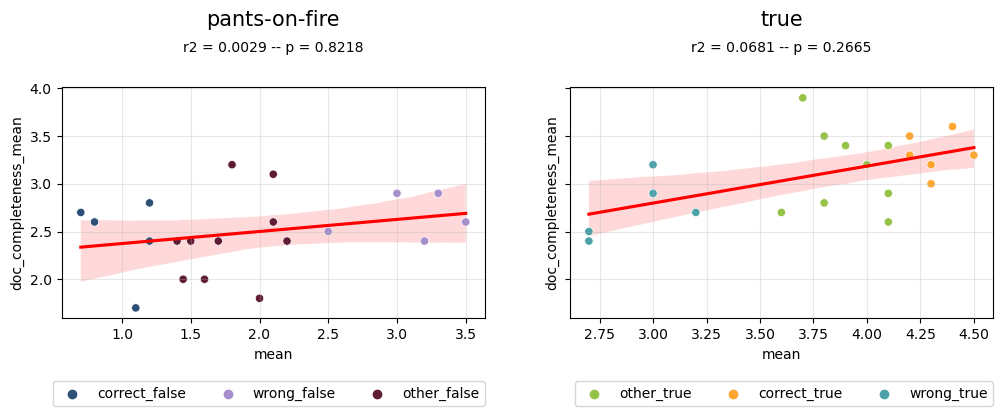

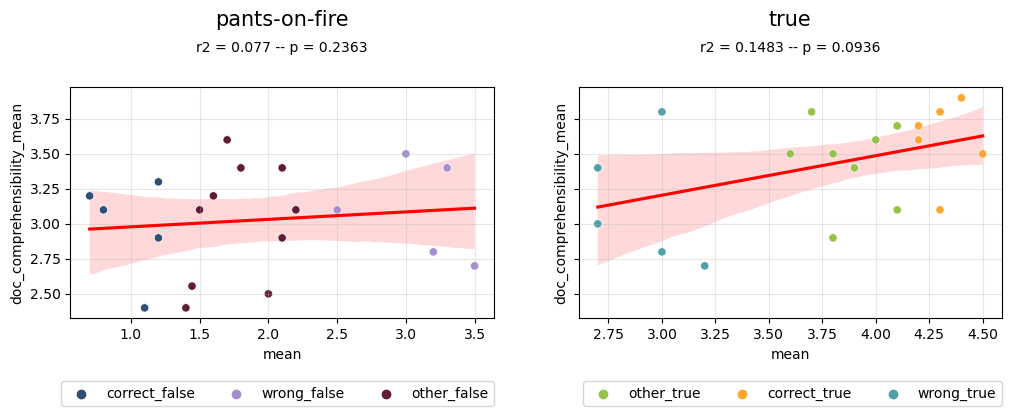

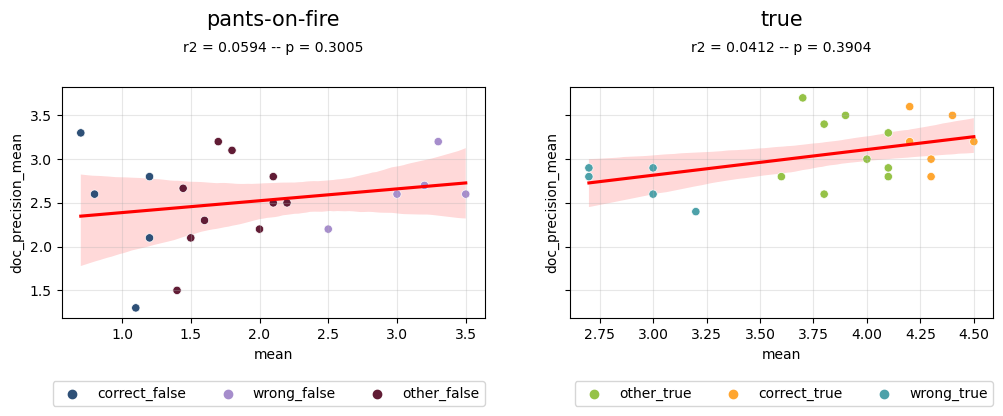

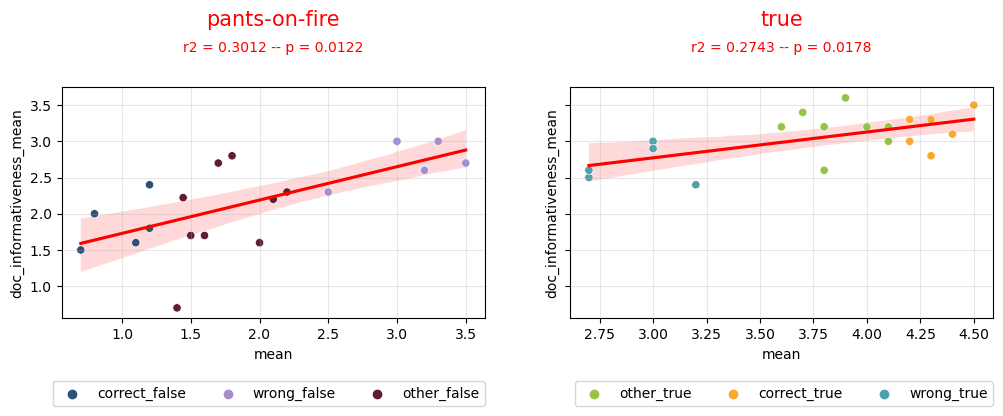

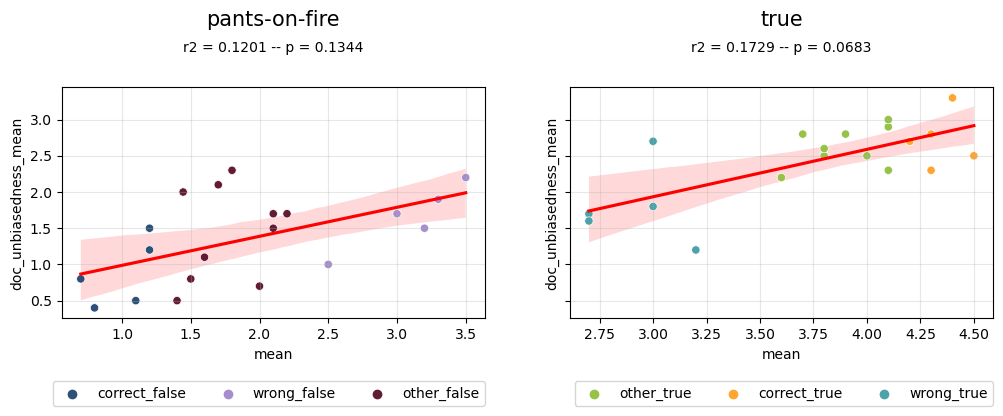

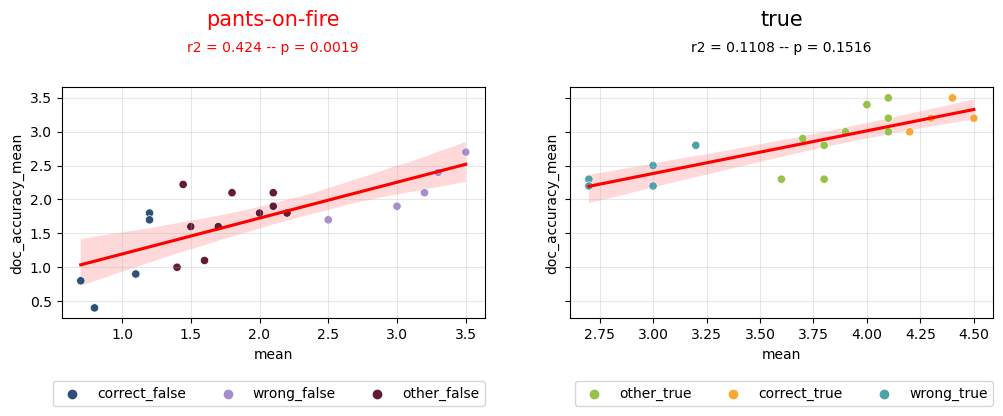

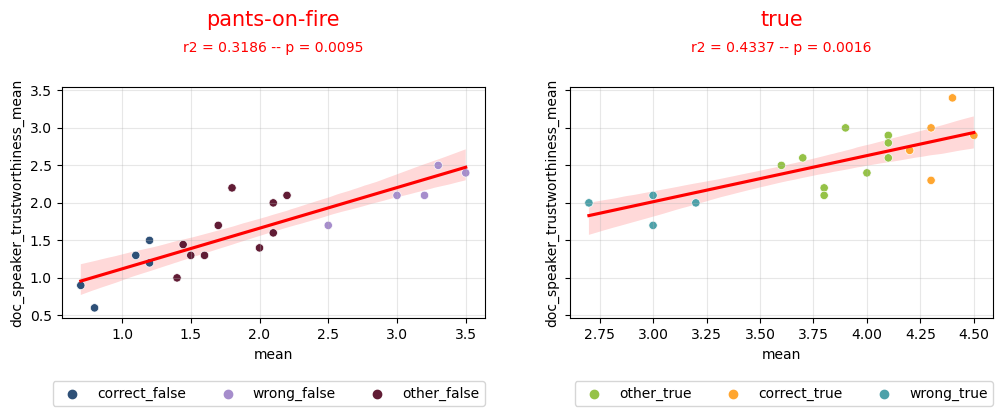

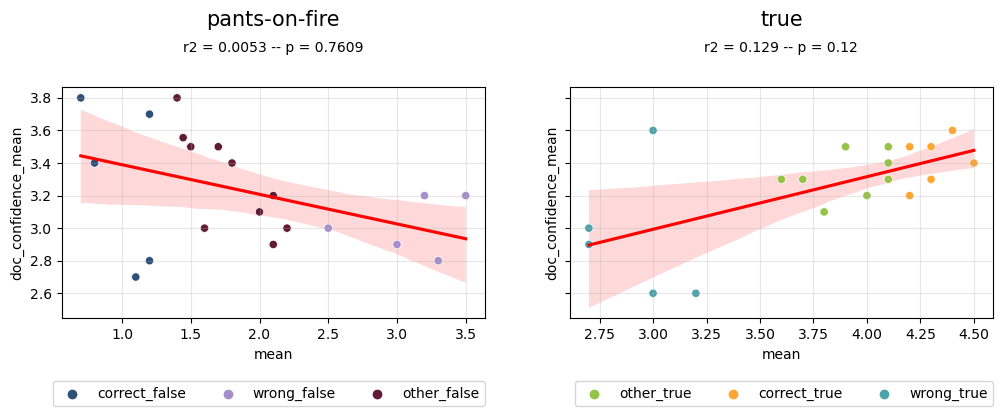

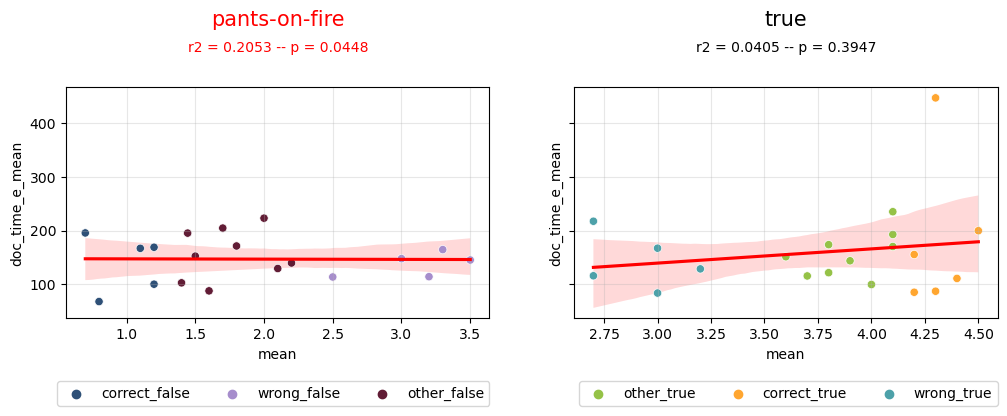

In [166]:
plot_regressione_lineare_RQ(df_all_con_medie,dimensioni_da_analizzare,6)

# Analisi medie

In [167]:
dimensioni_da_analizzare_con_mean = [dim[:-6]+"_mean" for dim in dimensioni_da_analizzare] + ["doc_time_e_mean"]

In [168]:
dimensioni_da_analizzare_con_mean

['doc_completeness_mean',
 'doc_comprehensibility_mean',
 'doc_precision_mean',
 'doc_informativeness_mean',
 'doc_unbiasedness_mean',
 'doc_accuracy_mean',
 'doc_speaker_trustworthiness_mean',
 'doc_confidence_mean',
 'doc_time_e_mean',
 'doc_time_e_mean']

In [169]:
# verifico se son tutti uguali => poichè son tutti uguali posso fare drop_by_doc_id
for doc_id in df_all_con_medie["doc_id"].unique():
    for dim in dimensioni_da_analizzare_con_mean:
        if len(df_all_con_medie[df_all_con_medie["doc_id"] == doc_id][dim].unique()) > 1:
            print(doc_id, dim)
    if len(df_all_con_medie[df_all_con_medie["doc_id"] == doc_id]["quartile"].unique()) > 1:
        print(doc_id,df_all_con_medie[df_all_con_medie["doc_id"] == doc_id]["quartile"].unique())


In [170]:
# elimino le righe duplicate
df_all_con_medie_analisi = df_all_con_medie.copy()
df_all_con_medie_analisi = df_all_con_medie_analisi.drop_duplicates(subset=["doc_id"])

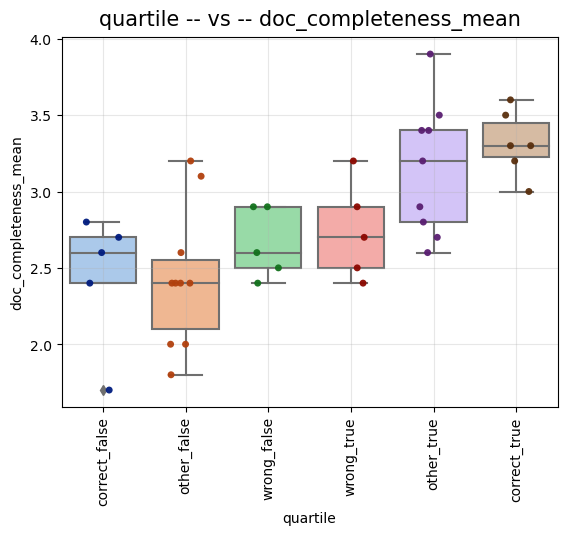

['wrong_true'] ['other_true' 'correct_true'] --> pvalue: 0.023


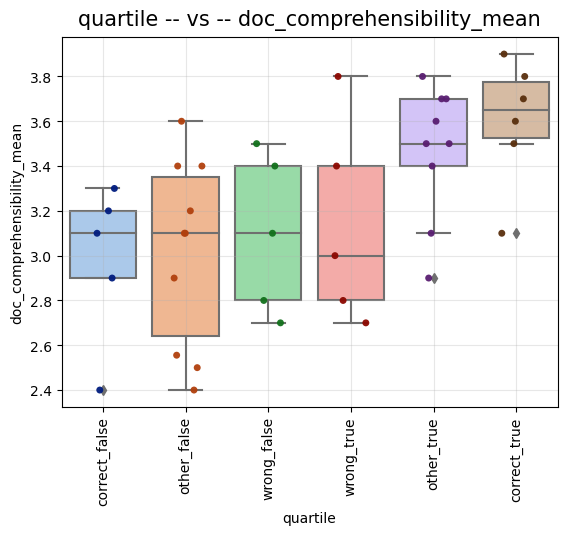

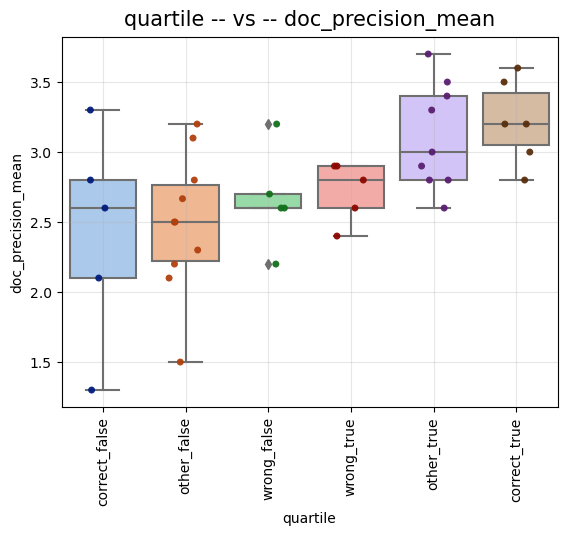

['wrong_true'] ['other_true' 'correct_true'] --> pvalue: 0.028


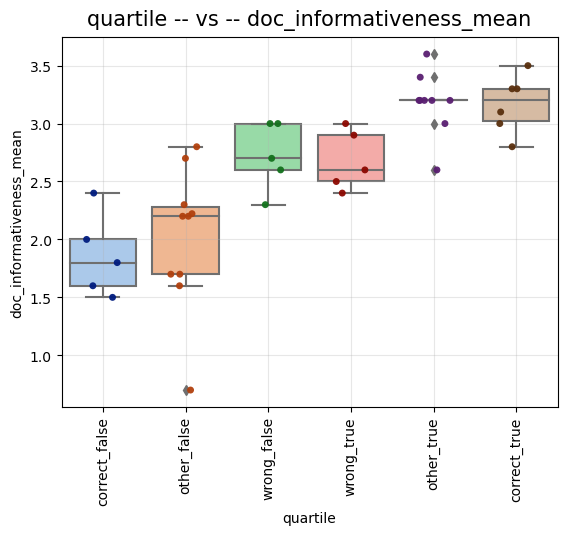

['wrong_false'] ['correct_false' 'other_false'] --> pvalue: 0.009
['wrong_true'] ['other_true' 'correct_true'] --> pvalue: 0.005


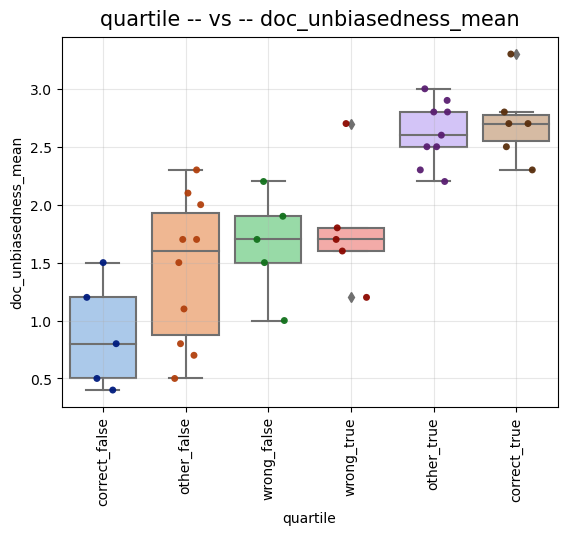

['correct_false'] ['wrong_false' 'other_false'] --> pvalue: 0.044
['wrong_true'] ['other_true' 'correct_true'] --> pvalue: 0.011


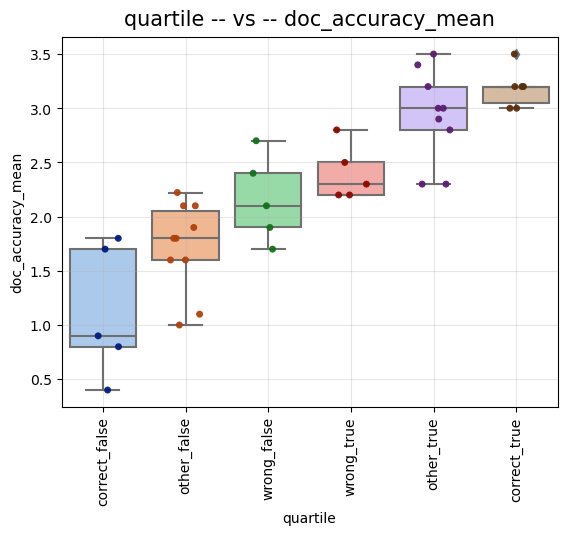

['wrong_false'] ['correct_false' 'other_false'] --> pvalue: 0.035
['correct_false'] ['wrong_false' 'other_false'] --> pvalue: 0.02
['wrong_true'] ['other_true' 'correct_true'] --> pvalue: 0.005
['correct_true'] ['other_true' 'wrong_true'] --> pvalue: 0.034


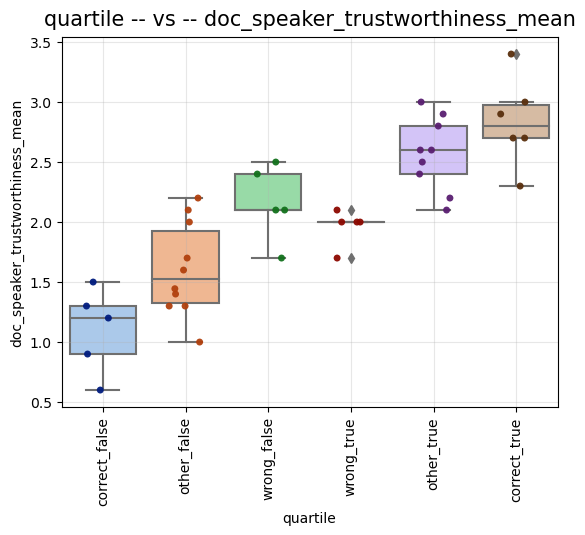

['wrong_false'] ['correct_false' 'other_false'] --> pvalue: 0.008
['correct_false'] ['wrong_false' 'other_false'] --> pvalue: 0.011
['wrong_true'] ['other_true' 'correct_true'] --> pvalue: 0.001
['correct_true'] ['other_true' 'wrong_true'] --> pvalue: 0.028


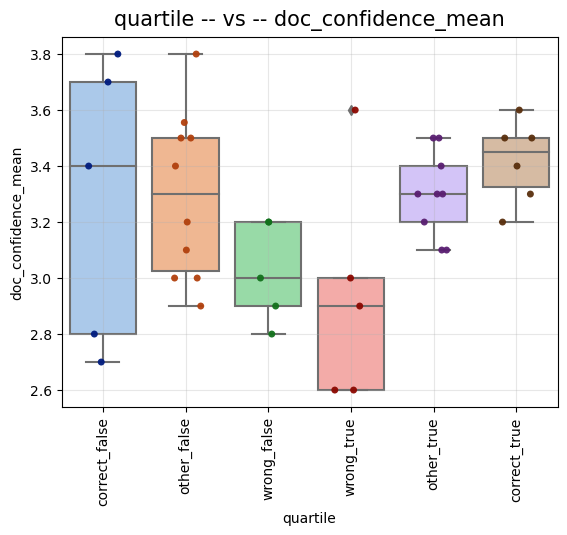

['wrong_true'] ['other_true' 'correct_true'] --> pvalue: 0.047


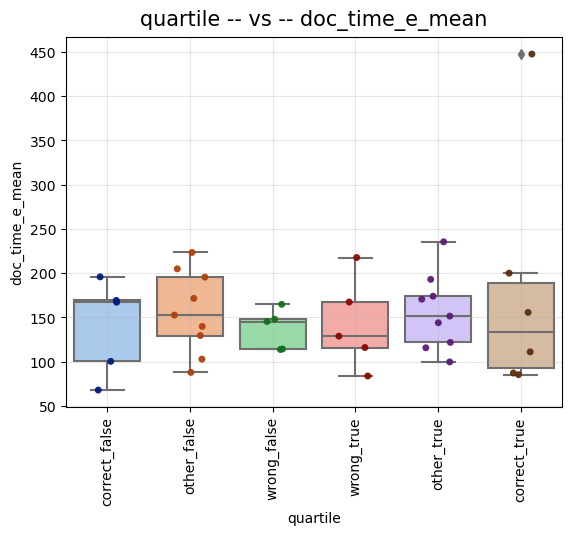

In [171]:
for dimensione in dimensioni_da_analizzare:
    # all
    crea_boxplot_e_stripplot(df_all_con_medie_analisi, "quartile", dimensione[:-6]+"_mean")
    calcola_test_mann(df_all_con_medie_analisi, dimensione[:-6]+"_mean",quartili, solo_significativi = True)
    # con raggruppamenti
    #crea_boxplot_e_stripplot(df_all_con_medie_analisi, "quartile", dimensione[:-6]+"_mean", gruppi = [["wrong_false", "correct_false"],["wrong_true", "correct_true"]],labels = ["false","true"],titolo = "Veridicità")
    #crea_boxplot_e_stripplot(df_all_con_medie_analisi, "quartile", dimensione[:-6]+"_mean",gruppi = [["wrong_false", "wrong_true"],["correct_true", "correct_false"]],labels = ["wrong","correct"],titolo = "Correttezza")

## Analisi tempo impiegato

In [172]:
df_all[["doc_time_elapsed","doc"]]

KeyError: "['doc'] not in index"

In [ ]:
valore_soglia = -1

In [ ]:
for variabile_interesse in ["correct_false", "wrong_false"]:
    for df in [["df_all",df_all], ["df_true",df_true], ["df_false",df_false]]:
        
        results = ols(
            f'''
                {variabile_interesse} ~ doc_time_elapsed """
            '''
            , data=df[1]).fit()
        aov_table = sm.stats.anova_lm(results, typ=2)
        anova_table_v = anova_table(aov_table)
        if anova_table_v["omega_sq"].max() > valore_soglia:
            print("-" * 100)
            print(f"""{variabile_interesse} ~ doc_time_elapsed  in {df[0]}""")
            display(anova_table_v.sort_values(by="omega_sq", ascending=False))
            
        for index, row in anova_table_v.iterrows():
            if row["omega_sq"] > 0.14:
                print(index)
                tukey_results = pairwise_tukeyhsd(endog=df[1][variabile_interesse], 
                                        groups=df[1][index], 
                                        alpha=0.05)
                
                df_turkey = pd.DataFrame(data=tukey_results._results_table.data[1:], columns=tukey_results._results_table.data[0])
                display(df_turkey[df_turkey["reject"] == True].sort_values(by="p-adj", ascending=True))

----------------------------------------------------------------------------------------------------
correct_false ~ doc_time_elapsed  in df_all


,sum_sq,df,mean_sq,F,PR(>F),eta_sq,omega_sq
doc_time_elapsed,0.002835,1.0,0.002835,0.07067,0.79041,0.000059,-0.000778
Residual,47.906864,1194.0,0.040123,NaN,NaN,NaN,NaN


----------------------------------------------------------------------------------------------------
correct_false ~ doc_time_elapsed  in df_false


,sum_sq,df,mean_sq,F,PR(>F),eta_sq,omega_sq
doc_time_elapsed,0.012306,1.0,0.012306,0.064557,0.7997,0.000329,-0.004747
Residual,37.361432,196.0,0.190620,NaN,NaN,NaN,NaN


----------------------------------------------------------------------------------------------------
wrong_false ~ doc_time_elapsed  in df_all


,sum_sq,df,mean_sq,F,PR(>F),eta_sq,omega_sq
doc_time_elapsed,0.005950,1.0,0.00595,0.148315,0.700219,0.000124,-0.000713
Residual,47.903749,1194.0,0.04012,NaN,NaN,NaN,NaN


----------------------------------------------------------------------------------------------------
wrong_false ~ doc_time_elapsed  in df_false


,sum_sq,df,mean_sq,F,PR(>F),eta_sq,omega_sq
doc_time_elapsed,0.036377,1.0,0.036377,0.190957,0.662602,0.000973,-0.004103
Residual,37.337361,196.0,0.190497,NaN,NaN,NaN,NaN


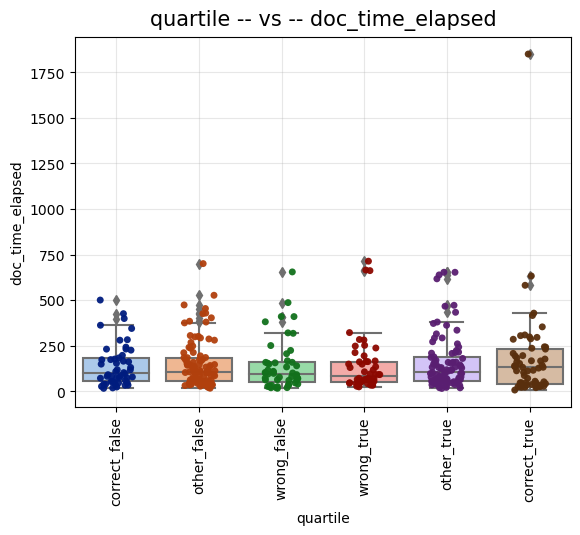

In [ ]:
crea_boxplot_e_stripplot(df_all, "quartile", "doc_time_elapsed")

In [ ]:
# calcolo media
for quartile in quartili:
    print(quartile,df_all[df_all["quartile"] == quartile]["doc_time_elapsed"].mean())

wrong_false 137.2924
correct_false 140.14579999999998
wrong_true 142.79160000000002
correct_true 181.1895


In [ ]:
calcola_test_mann(df_all, "doc_time_elapsed",quartili)

['wrong_false'] ['correct_false' 'other_false'] --> pvalue:  nan
['correct_false'] ['wrong_false' 'other_false'] --> pvalue:  nan
['wrong_true'] ['other_true' 'correct_true'] --> pvalue:  0.44872569755960856
['correct_true'] ['other_true' 'wrong_true'] --> pvalue:  0.8929038122106253


Notiamo che ci sono molti outliers

In [ ]:
all_index_to_remove = []
for quartile in quartili:
    
    df = df_all.copy()
    df = df[df["quartile"] == quartile]

    time = df['doc_time_elapsed']
    
    removed_outliers = time.between(time.quantile(.05), time.quantile(.95))
    
    index_names = df[~removed_outliers].index # INVERT removed_outliers!!
    
    for index in index_names:
        all_index_to_remove.append(index)
    
    df.drop(index_names, inplace=True)


<Axes: xlabel='quartile', ylabel='doc_time_elapsed'>

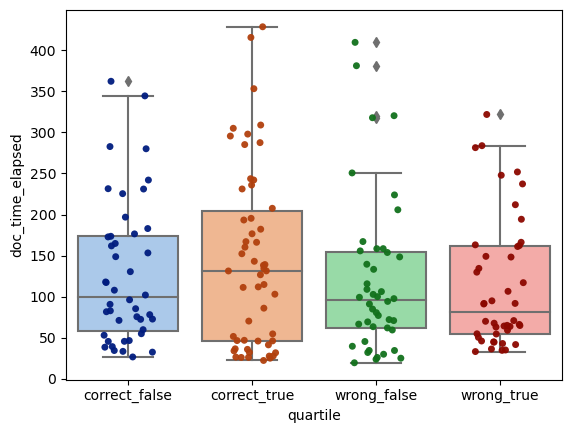

In [ ]:
df = df_all.copy()
df.drop(all_index_to_remove, inplace=True)
df = df[(df["quartile"] != "other") & (df["quartile"] != "other_true") & (df["quartile"] != "other_false")]

sns.boxplot(palette = "pastel",x="quartile", y="doc_time_elapsed", data=df)
sns.stripplot(palette = "dark",x="quartile", y="doc_time_elapsed", data=df, jitter=0.2, size=5, alpha=0.95)
    

In [ ]:
calcola_test_mann(df, "doc_time_elapsed",quartili)

['wrong_false'] ['correct_false'] --> pvalue:  0.42546382801883764
['correct_false'] ['wrong_false'] --> pvalue:  0.42546382801883764
['wrong_true'] ['correct_true'] --> pvalue:  0.49517062659851285
['correct_true'] ['wrong_true'] --> pvalue:  0.49517062659851285


usando questi dati ricalcolo la regressione:

In [ ]:
df = df_all.copy()
df.drop(all_index_to_remove, inplace=True)
df = df[(df["quartile"] != "other") ]

In [ ]:
dimensioni_da_analizzare = ["doc_time_elapsed"]

for dimensione in dimensioni_da_analizzare:
    df[dimensione[:-6]+"_mean"] = 0

for statement in df["doc_id"].unique():
    for dim in dimensioni_da_analizzare:
        mean = np.asarray(df[df["doc_id"] == statement][dim],dtype = np.float64).mean()
        df.loc[df_all_con_medie["doc_id"] == statement, dim[:-6]+"_mean"] = mean 

doc_time_elapsed


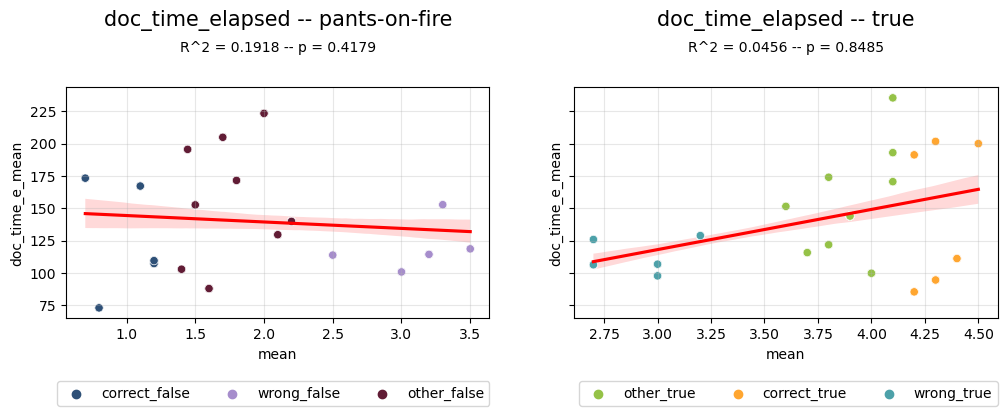

In [ ]:
plot_regressione_lineare_RQ(df,["doc_time_elapsed"],6)

## Salvo DataFrame

In [ ]:
df.to_csv(index=False, path_or_buf = "../Datasets/df_Q3.csv")

# Analisi Incrociata

In [ ]:
# importo dati
df_all = pd.read_csv(folder+"df_all_data.csv", sep=',').drop(columns=['Unnamed: 0'])
df_all["doc_index"] = df_all["doc_index"].apply(str)
df_all = calcola_scarto(df_all)
df_all = df_all.rename(columns={"doc_speaker's-trustworthiness_index": "doc_speaker_trustworthiness_index"})

In [ ]:
df_all["correct_false"] = 0
df_all["correct_true"] = 0
df_all["wrong_false"] = 0
df_all["wrong_true"] = 0

for index, row in df_all.iterrows():
    if row ["quartile"] == "correct_false":
        df_all.loc[index, "correct_false"] = 1
    if row ["quartile"] == "correct_true":
        df_all.loc[index, "correct_true"] = 1
    if row ["quartile"] == "wrong_false":
        df_all.loc[index, "wrong_false"] = 1
    if row ["quartile"] == "wrong_true":
        df_all.loc[index, "wrong_true"] = 1
        

In [ ]:
df_all, df_false, df_true , df_wrong, df_correct, df_wrong_false, df_correct_false, df_correct_true, df_wrong_true, DF_no_quartili, DF = crea_df_per_analisi(df_all)

In [ ]:
for variabile_interesse in ["doc_truthfulness_index","scarto", "mean"]:
    for df in DF_no_quartili:
        
        
        results = ols(
            f'''
                {variabile_interesse} ~  doc_accuracy_index*doc_speaker_trustworthiness_index*C(doc_speaker_party)  """
            '''
            , data=df[1]).fit()
        aov_table = sm.stats.anova_lm(results, typ=2)
        anova_table_v = anova_table(aov_table)
        if anova_table_v["omega_sq"].max() > 0.14:
            print("-" * 100)
            print(f"""{variabile_interesse} ~ doc_accuracy_index + doc_speaker_trustworthiness_index + C(doc_speaker_party) in {df[0]}""")
            display(anova_table_v.sort_values(by="omega_sq", ascending=False))
            
        for index, row in anova_table_v.iterrows():
            if row["omega_sq"] > 0.14:
                print(index)
                if index[0] == "C":
                    index = index[2:-1]
                
                tukey_results = pairwise_tukeyhsd(endog=df[1][variabile_interesse], 
                                        groups=df[1][index], 
                                        alpha=0.05)
                
                df_turkey = pd.DataFrame(data=tukey_results._results_table.data[1:], columns=tukey_results._results_table.data[0])
                display(df_turkey[df_turkey["reject"] == True].sort_values(by="p-adj", ascending=True))

----------------------------------------------------------------------------------------------------
doc_truthfulness_index ~ doc_accuracy_index + doc_speaker_trustworthiness_index + C(doc_speaker_party) in df_all


,sum_sq,df,mean_sq,F,PR(>F),eta_sq,omega_sq
doc_accuracy_index,423.680564,1.0,423.680564,345.030259,7.785865e-68,0.213895,0.213143
doc_speaker_trustworthiness_index,67.691024,1.0,67.691024,55.125143,2.147570e-13,0.034174,0.033533
doc_accuracy_index:doc_speaker_trustworthiness_index,14.145600,1.0,14.145600,11.519669,7.112915e-04,0.007141,0.006517
C(doc_speaker_party),12.594701,1.0,12.594701,10.256672,1.397966e-03,0.006358,0.005735
doc_speaker_trustworthiness_index:C(doc_speaker_party),0.080800,1.0,0.080800,0.065800,7.975970e-01,0.000041,-0.000579
doc_accuracy_index:doc_speaker_trustworthiness_index:C(doc_speaker_party),0.071607,1.0,0.071607,0.058314,8.092227e-01,0.000036,-0.000583
doc_accuracy_index:C(doc_speaker_party),0.028424,1.0,0.028424,0.023147,8.791000e-01,0.000014,-0.000605
Residual,1462.490720,1191.0,1.227952,NaN,NaN,NaN,NaN


doc_accuracy_index


,group1,group2,meandiff,p-adj,lower,upper,reject
0,0.0,1.0,1.0116,0.0,0.7130,1.3103,True
1,0.0,2.0,2.0165,0.0,1.7115,2.3216,True
2,0.0,3.0,2.8735,0.0,2.6014,3.1456,True
3,0.0,4.0,3.4046,0.0,3.1150,3.6942,True
4,1.0,2.0,1.0049,0.0,0.6992,1.3106,True
5,1.0,3.0,1.8618,0.0,1.5890,2.1347,True
6,1.0,4.0,2.3929,0.0,2.1026,2.6833,True
7,2.0,3.0,0.8569,0.0,0.5771,1.1367,True
8,2.0,4.0,1.3881,0.0,1.0912,1.6849,True
9,3.0,4.0,0.5311,0.0,0.2682,0.7940,True


----------------------------------------------------------------------------------------------------
doc_truthfulness_index ~ doc_accuracy_index + doc_speaker_trustworthiness_index + C(doc_speaker_party) in df_true


,sum_sq,df,mean_sq,F,PR(>F),eta_sq,omega_sq
doc_accuracy_index,84.971352,1.0,84.971352,110.061235,1.210405e-20,0.339567,0.335447
C(doc_speaker_party),8.730679,1.0,8.730679,11.308627,9.311602e-04,0.034890,0.031707
doc_accuracy_index:C(doc_speaker_party),3.656834,1.0,3.656834,4.736605,3.074799e-02,0.014614,0.011493
doc_speaker_trustworthiness_index,3.522200,1.0,3.522200,4.562216,3.395132e-02,0.014076,0.010957
doc_accuracy_index:doc_speaker_trustworthiness_index:C(doc_speaker_party),0.960867,1.0,0.960867,1.244587,2.659832e-01,0.003840,0.000752
doc_speaker_trustworthiness_index:C(doc_speaker_party),0.127502,1.0,0.127502,0.165151,6.849107e-01,0.000510,-0.002568
doc_accuracy_index:doc_speaker_trustworthiness_index,0.033575,1.0,0.033575,0.043489,8.350281e-01,0.000134,-0.002942
Residual,148.231115,192.0,0.772037,NaN,NaN,NaN,NaN


doc_accuracy_index


,group1,group2,meandiff,p-adj,lower,upper,reject
2,0.0,3.0,2.5235,0.0000,1.7388,3.3083,True
3,0.0,4.0,3.2682,0.0000,2.4895,4.0469,True
5,1.0,3.0,2.0565,0.0000,1.2956,2.8174,True
6,1.0,4.0,2.8012,0.0000,2.0465,3.5558,True
7,2.0,3.0,1.0788,0.0000,0.5224,1.6353,True
8,2.0,4.0,1.8235,0.0000,1.2756,2.3713,True
9,3.0,4.0,0.7447,0.0000,0.3080,1.1813,True
1,0.0,2.0,1.4447,0.0001,0.5931,2.2964,True
4,1.0,2.0,0.9777,0.0120,0.1479,1.8074,True


----------------------------------------------------------------------------------------------------
doc_truthfulness_index ~ doc_accuracy_index + doc_speaker_trustworthiness_index + C(doc_speaker_party) in df_wrong


,sum_sq,df,mean_sq,F,PR(>F),eta_sq,omega_sq
doc_accuracy_index,40.462816,1.0,40.462816,47.469191,6.801356e-10,0.316439,0.307722
doc_speaker_trustworthiness_index,4.220546,1.0,4.220546,4.951359,2.851445e-02,0.033007,0.026166
doc_accuracy_index:doc_speaker_trustworthiness_index,3.288608,1.0,3.288608,3.858050,5.252602e-02,0.025719,0.018926
C(doc_speaker_party),1.277775,1.0,1.277775,1.499029,2.239469e-01,0.009993,0.003305
doc_accuracy_index:doc_speaker_trustworthiness_index:C(doc_speaker_party),0.140795,1.0,0.140795,0.165174,6.853806e-01,0.001101,-0.005528
doc_speaker_trustworthiness_index:C(doc_speaker_party),0.047079,1.0,0.047079,0.055231,8.147209e-01,0.000368,-0.006256
doc_accuracy_index:C(doc_speaker_party),0.010651,1.0,0.010651,0.012495,9.112400e-01,0.000083,-0.006539
Residual,78.420951,92.0,0.852402,NaN,NaN,NaN,NaN


doc_accuracy_index


,group1,group2,meandiff,p-adj,lower,upper,reject
1,0.0,2.0,2.5417,0.0000,1.6081,3.4752,True
2,0.0,3.0,3.2500,0.0000,2.3390,4.1610,True
3,0.0,4.0,4.0000,0.0000,3.0359,4.9641,True
5,1.0,3.0,2.0625,0.0000,1.2350,2.8900,True
6,1.0,4.0,2.8125,0.0000,1.9269,3.6981,True
8,2.0,4.0,1.4583,0.0000,0.6589,2.2578,True
4,1.0,2.0,1.3542,0.0003,0.5020,2.2064,True
0,0.0,1.0,1.1875,0.0125,0.1792,2.1958,True


----------------------------------------------------------------------------------------------------
doc_truthfulness_index ~ doc_accuracy_index + doc_speaker_trustworthiness_index + C(doc_speaker_party) in df_correct


,sum_sq,df,mean_sq,F,PR(>F),eta_sq,omega_sq
doc_accuracy_index,54.054724,1.0,54.054724,94.123513,3.725390e-16,0.344215,0.339317
C(doc_speaker_party),26.936312,1.0,26.936312,46.903214,5.744730e-10,0.171527,0.167259
doc_accuracy_index:C(doc_speaker_party),8.558762,1.0,8.558762,14.903059,1.987650e-04,0.054501,0.050659
doc_speaker_trustworthiness_index,4.277019,1.0,4.277019,7.447416,7.483280e-03,0.027236,0.023493
doc_accuracy_index:doc_speaker_trustworthiness_index:C(doc_speaker_party),3.771727,1.0,3.771727,6.567570,1.184561e-02,0.024018,0.020287
doc_accuracy_index:doc_speaker_trustworthiness_index,0.842939,1.0,0.842939,1.467779,2.284958e-01,0.005368,0.001704
doc_speaker_trustworthiness_index:C(doc_speaker_party),0.018250,1.0,0.018250,0.031778,8.588699e-01,0.000116,-0.003528
Residual,58.578156,102.0,0.574296,NaN,NaN,NaN,NaN


C(doc_speaker_party)


,group1,group2,meandiff,p-adj,lower,upper,reject
0,DEM,REP,-2.8821,0.0,-3.4524,-2.3119,True


doc_accuracy_index


,group1,group2,meandiff,p-adj,lower,upper,reject
1,0.0,2.0,2.3055,0.0000,1.3182,3.2927,True
2,0.0,3.0,3.9162,0.0000,3.1879,4.6446,True
3,0.0,4.0,4.1738,0.0000,3.4291,4.9185,True
5,1.0,3.0,3.0793,0.0000,2.1819,3.9768,True
6,1.0,4.0,3.3369,0.0000,2.4261,4.2476,True
8,2.0,4.0,1.8683,0.0000,0.9021,2.8346,True
7,2.0,3.0,1.6108,0.0001,0.6571,2.5645,True
4,1.0,2.0,1.4685,0.0037,0.3507,2.5864,True


----------------------------------------------------------------------------------------------------
scarto ~ doc_accuracy_index + doc_speaker_trustworthiness_index + C(doc_speaker_party) in df_true


,sum_sq,df,mean_sq,F,PR(>F),eta_sq,omega_sq
doc_accuracy_index,84.971352,1.0,84.971352,110.061235,1.210405e-20,0.339567,0.335447
C(doc_speaker_party),8.730679,1.0,8.730679,11.308627,9.311602e-04,0.034890,0.031707
doc_accuracy_index:C(doc_speaker_party),3.656834,1.0,3.656834,4.736605,3.074799e-02,0.014614,0.011493
doc_speaker_trustworthiness_index,3.522200,1.0,3.522200,4.562216,3.395132e-02,0.014076,0.010957
doc_accuracy_index:doc_speaker_trustworthiness_index:C(doc_speaker_party),0.960867,1.0,0.960867,1.244587,2.659832e-01,0.003840,0.000752
doc_speaker_trustworthiness_index:C(doc_speaker_party),0.127502,1.0,0.127502,0.165151,6.849107e-01,0.000510,-0.002568
doc_accuracy_index:doc_speaker_trustworthiness_index,0.033575,1.0,0.033575,0.043489,8.350281e-01,0.000134,-0.002942
Residual,148.231115,192.0,0.772037,NaN,NaN,NaN,NaN


doc_accuracy_index


,group1,group2,meandiff,p-adj,lower,upper,reject
2,0.0,3.0,-2.5235,0.0000,-3.3083,-1.7388,True
3,0.0,4.0,-3.2682,0.0000,-4.0469,-2.4895,True
5,1.0,3.0,-2.0565,0.0000,-2.8174,-1.2956,True
6,1.0,4.0,-2.8012,0.0000,-3.5558,-2.0465,True
7,2.0,3.0,-1.0788,0.0000,-1.6353,-0.5224,True
8,2.0,4.0,-1.8235,0.0000,-2.3713,-1.2756,True
9,3.0,4.0,-0.7447,0.0000,-1.1813,-0.3080,True
1,0.0,2.0,-1.4447,0.0001,-2.2964,-0.5931,True
4,1.0,2.0,-0.9777,0.0120,-1.8074,-0.1479,True


----------------------------------------------------------------------------------------------------
mean ~ doc_accuracy_index + doc_speaker_trustworthiness_index + C(doc_speaker_party) in df_false


,sum_sq,df,mean_sq,F,PR(>F),eta_sq,omega_sq
C(doc_speaker_party),17.374050,1.0,17.374050,36.990756,6.344855e-09,0.146481,0.141959
doc_accuracy_index:C(doc_speaker_party),3.843643,1.0,3.843643,8.183426,4.698208e-03,0.032406,0.028334
doc_accuracy_index:doc_speaker_trustworthiness_index:C(doc_speaker_party),2.857017,1.0,2.857017,6.082819,1.453187e-02,0.024088,0.020048
doc_speaker_trustworthiness_index:C(doc_speaker_party),1.778054,1.0,1.778054,3.785621,5.316231e-02,0.014991,0.010987
doc_accuracy_index,1.078810,1.0,1.078810,2.296874,1.312879e-01,0.009095,0.005115
doc_accuracy_index:doc_speaker_trustworthiness_index,1.078624,1.0,1.078624,2.296477,1.313209e-01,0.009094,0.005114
doc_speaker_trustworthiness_index,0.888967,1.0,0.888967,1.892683,1.705107e-01,0.007495,0.003521
Residual,89.710077,191.0,0.469686,NaN,NaN,NaN,NaN


C(doc_speaker_party)


,group1,group2,meandiff,p-adj,lower,upper,reject
0,DEM,REP,-0.7116,0.0,-0.9376,-0.4857,True


----------------------------------------------------------------------------------------------------
mean ~ doc_accuracy_index + doc_speaker_trustworthiness_index + C(doc_speaker_party) in df_true


,sum_sq,df,mean_sq,F,PR(>F),eta_sq,omega_sq
C(doc_speaker_party),24.223005,1.0,24.223005,167.292840,6.266612e-28,0.439984,0.436207
doc_accuracy_index,2.047992,1.0,2.047992,14.144173,2.247255e-04,0.037200,0.034479
doc_accuracy_index:C(doc_speaker_party),0.611595,1.0,0.611595,4.223898,4.121241e-02,0.011109,0.008457
doc_speaker_trustworthiness_index:C(doc_speaker_party),0.154294,1.0,0.154294,1.065609,3.032379e-01,0.002803,0.000172
doc_accuracy_index:doc_speaker_trustworthiness_index,0.112003,1.0,0.112003,0.773534,3.802255e-01,0.002034,-0.000594
doc_speaker_trustworthiness_index,0.101986,1.0,0.101986,0.704351,4.023694e-01,0.001852,-0.000776
doc_accuracy_index:doc_speaker_trustworthiness_index:C(doc_speaker_party),0.002948,1.0,0.002948,0.020360,8.866860e-01,0.000054,-0.002570
Residual,27.800455,192.0,0.144794,NaN,NaN,NaN,NaN


C(doc_speaker_party)


,group1,group2,meandiff,p-adj,lower,upper,reject
0,DEM,REP,-0.7792,0.0,-0.8932,-0.6651,True


----------------------------------------------------------------------------------------------------
mean ~ doc_accuracy_index + doc_speaker_trustworthiness_index + C(doc_speaker_party) in df_wrong


,sum_sq,df,mean_sq,F,PR(>F),eta_sq,omega_sq
C(doc_speaker_party),2.168550,1.0,2.168550,33.314873,1.048857e-07,0.256205,0.246618
doc_accuracy_index,0.212709,1.0,0.212709,3.267798,7.392036e-02,0.025131,0.017307
doc_accuracy_index:doc_speaker_trustworthiness_index:C(doc_speaker_party),0.052839,1.0,0.052839,0.811749,3.699561e-01,0.006243,-0.001437
doc_speaker_trustworthiness_index,0.027175,1.0,0.027175,0.417476,5.198078e-01,0.003211,-0.004446
doc_accuracy_index:C(doc_speaker_party),0.007841,1.0,0.007841,0.120454,7.293357e-01,0.000926,-0.006712
doc_speaker_trustworthiness_index:C(doc_speaker_party),0.005570,1.0,0.005570,0.085563,7.705543e-01,0.000658,-0.006979
doc_accuracy_index:doc_speaker_trustworthiness_index,0.000921,1.0,0.000921,0.014142,9.055978e-01,0.000109,-0.007524
Residual,5.988514,92.0,0.065093,NaN,NaN,NaN,NaN


C(doc_speaker_party)


,group1,group2,meandiff,p-adj,lower,upper,reject
0,DEM,REP,-0.319,0.0,-0.4293,-0.2088,True


----------------------------------------------------------------------------------------------------
mean ~ doc_accuracy_index + doc_speaker_trustworthiness_index + C(doc_speaker_party) in df_correct


,sum_sq,df,mean_sq,F,PR(>F),eta_sq,omega_sq
C(doc_speaker_party),85.265569,1.0,85.265569,196.129241,1.695650e-25,0.543769,0.539501
doc_accuracy_index,11.901885,1.0,11.901885,27.376908,8.981336e-07,0.075903,0.072928
doc_accuracy_index:C(doc_speaker_party),5.649950,1.0,5.649950,12.996106,4.848157e-04,0.036032,0.033167
doc_accuracy_index:doc_speaker_trustworthiness_index,5.097712,1.0,5.097712,11.725839,8.889620e-04,0.032510,0.029655
doc_accuracy_index:doc_speaker_trustworthiness_index:C(doc_speaker_party),3.322430,1.0,3.322430,7.642308,6.767236e-03,0.021188,0.018365
doc_speaker_trustworthiness_index:C(doc_speaker_party),1.095570,1.0,1.095570,2.520048,1.155024e-01,0.006987,0.004203
doc_speaker_trustworthiness_index,0.127849,1.0,0.127849,0.294080,5.888004e-01,0.000815,-0.001952
Residual,44.343658,102.0,0.434742,NaN,NaN,NaN,NaN


C(doc_speaker_party)


,group1,group2,meandiff,p-adj,lower,upper,reject
0,DEM,REP,-2.8821,0.0,-3.2437,-2.5206,True


In [ ]:
for variabile_interesse in ["correct_true", "wrong_true"]:
    for df in [["df_all",df_all], ["df_true",df_true]]:
        
        results = ols(
            f'''
                {variabile_interesse} ~  doc_accuracy_index*doc_speaker_trustworthiness_index*C(doc_speaker_party)  """
            '''
            , data=df[1]).fit()
        aov_table = sm.stats.anova_lm(results, typ=2)
        anova_table_v = anova_table(aov_table)
        if anova_table_v["omega_sq"].max() > 0.14:
            print("-" * 100)
            print(f"""{variabile_interesse} ~ doc_accuracy_index + doc_speaker_trustworthiness_index + C(doc_speaker_party) in {df[0]}""")
            display(anova_table_v.sort_values(by="omega_sq", ascending=False))
            
        for index, row in anova_table_v.iterrows():
            if row["omega_sq"] > 0.14:
                print(index)
                if index[0] == "C":
                    index = index[2:-1]
                
                tukey_results = pairwise_tukeyhsd(endog=df[1][variabile_interesse], 
                                        groups=df[1][index], 
                                        alpha=0.05)
                
                df_turkey = pd.DataFrame(data=tukey_results._results_table.data[1:], columns=tukey_results._results_table.data[0])
                display(df_turkey[df_turkey["reject"] == True].sort_values(by="p-adj", ascending=True))

----------------------------------------------------------------------------------------------------
correct_true ~ doc_accuracy_index + doc_speaker_trustworthiness_index + C(doc_speaker_party) in df_true


,sum_sq,df,mean_sq,F,PR(>F),eta_sq,omega_sq
C(doc_speaker_party),10.307023,1.0,10.307023,69.861404,1.266908e-14,0.256759,0.252157
doc_accuracy_index:doc_speaker_trustworthiness_index:C(doc_speaker_party),0.410786,1.0,0.410786,2.784325,9.682065e-02,0.010233,0.006534
doc_accuracy_index,0.391731,1.0,0.391731,2.655169,1.048534e-01,0.009758,0.006061
doc_accuracy_index:C(doc_speaker_party),0.391167,1.0,0.391167,2.651345,1.051021e-01,0.009744,0.006047
doc_accuracy_index:doc_speaker_trustworthiness_index,0.314676,1.0,0.314676,2.132889,1.458032e-01,0.007839,0.004148
doc_speaker_trustworthiness_index:C(doc_speaker_party),0.000520,1.0,0.000520,0.003524,9.527219e-01,0.000013,-0.003649
doc_speaker_trustworthiness_index,0.000097,1.0,0.000097,0.000655,9.796061e-01,0.000002,-0.003659
Residual,28.326776,192.0,0.147535,NaN,NaN,NaN,NaN


C(doc_speaker_party)


,group1,group2,meandiff,p-adj,lower,upper,reject
0,DEM,REP,-0.5,0.0,-0.6108,-0.3892,True


----------------------------------------------------------------------------------------------------
wrong_true ~ doc_accuracy_index + doc_speaker_trustworthiness_index + C(doc_speaker_party) in df_true


,sum_sq,df,mean_sq,F,PR(>F),eta_sq,omega_sq
C(doc_speaker_party),15.669246,1.0,15.669246,182.312065,1.202478e-29,0.464207,0.460488
doc_accuracy_index:C(doc_speaker_party),0.774109,1.0,0.774109,9.006782,3.047007e-03,0.022933,0.020335
doc_accuracy_index,0.592345,1.0,0.592345,6.891946,9.356002e-03,0.017548,0.014964
doc_speaker_trustworthiness_index:C(doc_speaker_party),0.058447,1.0,0.058447,0.680035,4.105980e-01,0.001732,-0.000813
doc_accuracy_index:doc_speaker_trustworthiness_index,0.058062,1.0,0.058062,0.675551,4.121423e-01,0.001720,-0.000824
doc_speaker_trustworthiness_index,0.056310,1.0,0.056310,0.655171,4.192717e-01,0.001668,-0.000876
doc_accuracy_index:doc_speaker_trustworthiness_index:C(doc_speaker_party),0.044477,1.0,0.044477,0.517496,4.727866e-01,0.001318,-0.001225
Residual,16.501899,192.0,0.085947,NaN,NaN,NaN,NaN


C(doc_speaker_party)


,group1,group2,meandiff,p-adj,lower,upper,reject
0,DEM,REP,0.625,0.0,0.5374,0.7126,True


In [ ]:
for variabile_interesse in ["correct_false", "wrong_false"]:
    for df in [["df_all",df_all], ["df_false",df_false]]:
        
        results = ols(
            f'''
                {variabile_interesse} ~  doc_accuracy_index*doc_speaker_trustworthiness_index*C(doc_speaker_party)  """
            '''
            , data=df[1]).fit()
        aov_table = sm.stats.anova_lm(results, typ=2)
        anova_table_v = anova_table(aov_table)
        if anova_table_v["omega_sq"].max() > 0.05:
            print("-" * 100)
            print(f"""{variabile_interesse} ~ doc_accuracy_index + doc_speaker_trustworthiness_index + C(doc_speaker_party) in {df[0]}""")
            display(anova_table_v.sort_values(by="omega_sq", ascending=False))
            
        for index, row in anova_table_v.iterrows():
            if row["omega_sq"] > 0.14:
                print(index)
                if index[0] == "C":
                    index = index[2:-1]
                
                tukey_results = pairwise_tukeyhsd(endog=df[1][variabile_interesse], 
                                        groups=df[1][index], 
                                        alpha=0.05)
                
                df_turkey = pd.DataFrame(data=tukey_results._results_table.data[1:], columns=tukey_results._results_table.data[0])
                display(df_turkey[df_turkey["reject"] == True].sort_values(by="p-adj", ascending=True))

----------------------------------------------------------------------------------------------------
wrong_false ~ doc_accuracy_index + doc_speaker_trustworthiness_index + C(doc_speaker_party) in df_false


,sum_sq,df,mean_sq,F,PR(>F),eta_sq,omega_sq
C(doc_speaker_party),4.479746,1.0,4.479746,29.455889,1.721283e-07,0.126112,0.121311
doc_accuracy_index:C(doc_speaker_party),0.722515,1.0,0.722515,4.750790,3.050820e-02,0.020340,0.015990
doc_accuracy_index:doc_speaker_trustworthiness_index:C(doc_speaker_party),0.575670,1.0,0.575670,3.785229,5.317451e-02,0.016206,0.011874
doc_accuracy_index:doc_speaker_trustworthiness_index,0.257496,1.0,0.257496,1.693123,1.947573e-01,0.007249,0.002955
doc_speaker_trustworthiness_index,0.195507,1.0,0.195507,1.285524,2.582955e-01,0.005504,0.001217
doc_speaker_trustworthiness_index:C(doc_speaker_party),0.188792,1.0,0.188792,1.241370,2.666073e-01,0.005315,0.001029
doc_accuracy_index,0.054287,1.0,0.054287,0.356955,5.509101e-01,0.001528,-0.002741
Residual,29.047895,191.0,0.152083,NaN,NaN,NaN,NaN
